# ECE 498 DS Mini Project 2 - Checkpoint 1

$
\textbf{Group members (all registered):}\\ \ \\
\text{Boyang Zhou (NetID: boyangz3)}\\
\text{Chuhao Feng (NetID: chuhaof2)}\\
\text{Mengxuan Yu (NetID: my13)}\\ 
$

In [1]:
# import necessary module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import sklearn as skl

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GaussianMixture
from scipy.cluster import hierarchy
from sklearn.cluster import AgglomerativeClustering

In [2]:
# adjust format
sns.set()

In [3]:
# import dataset

# import RelativeAbundance_HE0.csv as data_HE0
data_HE0 = pd.read_csv('RelativeAbundance_HE0.csv')
# import RelativeAbundance_HE0.csv as data_HE1
data_HE1 = pd.read_csv('RelativeAbundance_HE1.csv')
# import QualityControl.csv as qual_con
qual_con = pd.read_csv('QualityControl.csv')
# import BayesInferenceHE0.csv as BI_HE0
BI_HE0 = pd.read_csv('BayesInferenceHE0.csv')
# import BayesInferenceHE1.csv as BI_HE1
BI_HE1 = pd.read_csv('BayesInferenceHE1.csv')

# Task 1: Data Cleaning and Visual Inspection

## 0. Getting Started With the Data

### 1. 

$
\text{According to law of large numbers, the average of the results obtained from a large number of trials should be close to the}\\
\text{expected value and will tend to become closer to the expected value as more trials are performed. Therefore, a large number of}\\
\text{samples are more likely to represent the real situation accurately than less samples.}
$

### 2. 

In [4]:
sample_anal = data_HE0.shape[1]-1
print('Number of samples analyzed:', sample_anal)

Number of samples analyzed: 764


### 3. 

In [5]:
micro_iden = data_HE0.shape[0]
print('Number of microbes:', micro_iden)

Number of microbes: 149


## 1. Bayesian Network for Quality Control

### a. Joint Probability Factorization

$
\text{Storage Temp:}\ S\\
\text{Collection Method:}\ CM\\
\text{Contamination:}\ CO\\
\text{Lab Time Before Processing:}\ L\\
\text{Quality:}\ Q\\
\ \\
P(S,CM,CO,L,Q)
=P(Q|CO,L,S,CM)P(L|CO,S,CM)P(CO|S,CM)P(S|CM)P(CM)\\
\ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ \ =P(Q|CO,L)P(L)P(CO|S,CM)P(CM)P(S)
$

### b. Parameters Required

$
\text{# of parameters needed} = \underbrace{4}_{P(Q|CO,L)} + \underbrace{1}_{P(L)} + \underbrace{4}_{P(CO|S,CM)}
+ \underbrace{1}_{P(CM)} + \underbrace{1}_{P(S)} = 11
$

### c. Constructing Probability Tables

In [6]:
# calculate P(Quality|Contamination, Lab Time)
P_labtime_cont = qual_con.groupby(['labtime','cont','qual']).size() / qual_con.groupby(['labtime','cont']).size()

In [7]:
# generate Table of P(Quality|Contamination, Lab Time)
labtime = ['long','long','short','short']
cont = ['high','low','high','low']
goods = [P_labtime_cont.iloc[1],P_labtime_cont.iloc[3],P_labtime_cont.iloc[5],P_labtime_cont.iloc[7]]
bads  = [P_labtime_cont.iloc[0],P_labtime_cont.iloc[2],P_labtime_cont.iloc[4],P_labtime_cont.iloc[6]]
table_labtime_cont = pd.DataFrame({"Lab Time": labtime, "Contamination": cont,"Good": goods, "Bad": bads})

print("Table of P(Quality|Contamination, Lab Time)")
table_labtime_cont

Table of P(Quality|Contamination, Lab Time)


Lab Time Contamination      Good       Bad
0     long          high  0.033898  0.966102
1     long           low  0.919003  0.080997
2    short          high  0.935743  0.064257
3    short           low  0.957093  0.042907

In [8]:
# calculate P(Contamination|Store Temperature, Collection Method)
P_strtmp_coll = qual_con.groupby(['strtmp','coll','cont']).size() / qual_con.groupby(['strtmp','coll']).size()

In [9]:
# generate Table of P(Contamination|Store Temperature, Collection Method)
strtmp = ['cold','cold','cool','cool']
coll   = ['nurse','patient','nurse','patient']
lows   = [P_strtmp_coll.iloc[1],P_strtmp_coll.iloc[3],P_strtmp_coll.iloc[5],P_strtmp_coll.iloc[7]]
highs  = [P_strtmp_coll.iloc[0],P_strtmp_coll.iloc[2],P_strtmp_coll.iloc[4],P_strtmp_coll.iloc[6]]
table_strtmp_coll = pd.DataFrame({"Storage Temp": strtmp, "Collection Method": coll,"High": highs, "Low": lows})

print("Table of P(Contamination|Store Temperature, Collection Method)")
table_strtmp_coll

Table of P(Contamination|Store Temperature, Collection Method)


Storage Temp Collection Method      High       Low
0         cold             nurse  0.043983  0.956017
1         cold           patient  0.076577  0.923423
2         cool             nurse  0.088435  0.911565
3         cool           patient  0.838235  0.161765

In [10]:
# generate Table of P(Store Temperature), P(Collection Method) and P(Lab Time) 
P_strtmp = qual_con.groupby('strtmp').size() / len(qual_con)
P_coll = qual_con.groupby('coll').size() / len(qual_con)
P_labtime = qual_con.groupby('labtime').size() / len(qual_con)

In [11]:
# generate Table of P(Store Temperature)
table_strtmp = pd.DataFrame({"Category":["Store Temperature"], "cold": [P_strtmp.iloc[0]], "cool":[ P_strtmp.iloc[1]]})
print("Table of P(Store Temperature)")
table_strtmp

Table of P(Store Temperature)


Category    cold    cool
0  Store Temperature  0.8982  0.1018

In [12]:
# generate Table of P(Collection Method)
table_coll = pd.DataFrame({"Category":["Collection Method"], "nurse": [P_coll.iloc[0]], "patient":[ P_coll.iloc[1]]})
print("Table of P(Collection Method)")
table_coll

Table of P(Collection Method)


Category   nurse  patient
0  Collection Method  0.8976   0.1024

In [13]:
# generate Table of P(Lab Time)
table_labtime = pd.DataFrame({"Category":["Lab Time"], "long": [P_labtime.iloc[0]], "short":[ P_labtime.iloc[1]]})
print("Table of P(Lab Time)")
table_labtime

Table of P(Lab Time)


Category    long   short
0  Lab Time  0.2044  0.7956

### d. Final Probability Tables

In [14]:
# calculate P(Quality|Storage Temp, Collection Method, Lab Time)
P_pos_Q_SCL = qual_con.groupby(['strtmp','coll','labtime','qual']).size() / qual_con.groupby(['strtmp','coll','labtime']).size()

In [15]:
# generate Table of P(Quality|Storage Temp, Collection Method, Lab Time)
strtmp = ['cold','cold','cold','cold',
          'cool','cool','cool','cool']
coll = ['nurse','nurse','patient','patient',
        'nurse','nurse','patient','patient']
labtime = ['long','short','long','short',
           'long','short','long','short']
conditions = ['(cold,nurse,long)','(cold,nurse,short)','(cold,patient,long)','(cold,patient,short)',
              '(cool,nurse,long)','(cool,nurse,short)','(cool,patient,long)','(cool,patient,short)']
goods = [P_pos_Q_SCL.iloc[1],P_pos_Q_SCL.iloc[3],P_pos_Q_SCL.iloc[5],P_pos_Q_SCL.iloc[7],
         P_pos_Q_SCL.iloc[9],P_pos_Q_SCL.iloc[11],P_pos_Q_SCL.iloc[13],P_pos_Q_SCL.iloc[15]]
bads = [P_pos_Q_SCL.iloc[0],P_pos_Q_SCL.iloc[2],P_pos_Q_SCL.iloc[4],P_pos_Q_SCL.iloc[6],
        P_pos_Q_SCL.iloc[8],P_pos_Q_SCL.iloc[10],P_pos_Q_SCL.iloc[12],P_pos_Q_SCL.iloc[14]]
table_P_pos = pd.DataFrame({"Storage Temp": strtmp, "Collection Method": coll, "Lab Time": labtime,"Good": goods, "Bad": bads})

print("Table of P(Quality|Storage Temp, Collection Method, Lab Time)")
table_P_pos

Table of P(Quality|Storage Temp, Collection Method, Lab Time)


Storage Temp Collection Method Lab Time      Good       Bad
0         cold             nurse     long  0.887962  0.112038
1         cold             nurse    short  0.955112  0.044888
2         cold           patient     long  0.862069  0.137931
3         cold           patient    short  0.943978  0.056022
4         cool             nurse     long  0.822785  0.177215
5         cool             nurse    short  0.972376  0.027624
6         cool           patient     long  0.117647  0.882353
7         cool           patient    short  0.960784  0.039216

### e. Cleaning the dataset

In [16]:
# determine the quality for HE0
bad_sample_HE0 = []
for i in range(BI_HE0.shape[0]):
    if BI_HE0.iloc[i,1] == "cool" and BI_HE0.iloc[i,2] == "patient" and BI_HE0.iloc[i,3] == "long":
        # the only bad samples according to the calculated conditional probability
        bad_sample_HE0.append(BI_HE0.iloc[i,0])

print("Samples for HE0\n")
print("Bad samples:\n", bad_sample_HE0)
print("\nTotal number of bad samples dropped:", len(bad_sample_HE0))

Samples for HE0

Bad samples:
 ['HE0Sample_699', 'HE0Sample_700', 'HE0Sample_701', 'HE0Sample_702', 'HE0Sample_703', 'HE0Sample_704', 'HE0Sample_705', 'HE0Sample_706', 'HE0Sample_707', 'HE0Sample_708', 'HE0Sample_709', 'HE0Sample_710', 'HE0Sample_711', 'HE0Sample_712', 'HE0Sample_713', 'HE0Sample_714', 'HE0Sample_715', 'HE0Sample_716', 'HE0Sample_717', 'HE0Sample_718', 'HE0Sample_719', 'HE0Sample_720', 'HE0Sample_721', 'HE0Sample_722', 'HE0Sample_723', 'HE0Sample_724', 'HE0Sample_725', 'HE0Sample_726', 'HE0Sample_727', 'HE0Sample_728', 'HE0Sample_729', 'HE0Sample_730', 'HE0Sample_731', 'HE0Sample_732', 'HE0Sample_733', 'HE0Sample_734', 'HE0Sample_735', 'HE0Sample_736', 'HE0Sample_737', 'HE0Sample_738', 'HE0Sample_739', 'HE0Sample_740', 'HE0Sample_741', 'HE0Sample_742', 'HE0Sample_743', 'HE0Sample_744', 'HE0Sample_745', 'HE0Sample_746', 'HE0Sample_747', 'HE0Sample_748', 'HE0Sample_749', 'HE0Sample_750', 'HE0Sample_751', 'HE0Sample_752', 'HE0Sample_753', 'HE0Sample_754', 'HE0Sample_755',

In [17]:
# determine the quality for HE1
bad_sample_HE1 = []
for i in range(BI_HE1.shape[0]):
    if BI_HE1.iloc[i,1] == "cool" and BI_HE1.iloc[i,2] == "patient" and BI_HE1.iloc[i,3] == "long":
        # the only bad samples according to the calculated conditional probability
        bad_sample_HE1.append(BI_HE1.iloc[i,0])

print("Samples for HE1\n")
print("Bad samples:\n", bad_sample_HE1)
print("\nTotal number of bad samples dropped:", len(bad_sample_HE1))

Samples for HE1

Bad samples:
 ['HE1Sample_699', 'HE1Sample_700', 'HE1Sample_701', 'HE1Sample_702', 'HE1Sample_703', 'HE1Sample_704', 'HE1Sample_705', 'HE1Sample_706', 'HE1Sample_707', 'HE1Sample_708', 'HE1Sample_709', 'HE1Sample_710', 'HE1Sample_711', 'HE1Sample_712', 'HE1Sample_713', 'HE1Sample_714', 'HE1Sample_715', 'HE1Sample_716', 'HE1Sample_717', 'HE1Sample_718', 'HE1Sample_719', 'HE1Sample_720', 'HE1Sample_721', 'HE1Sample_722', 'HE1Sample_723', 'HE1Sample_724', 'HE1Sample_725', 'HE1Sample_726', 'HE1Sample_727', 'HE1Sample_728', 'HE1Sample_729', 'HE1Sample_730', 'HE1Sample_731', 'HE1Sample_732', 'HE1Sample_733', 'HE1Sample_734', 'HE1Sample_735', 'HE1Sample_736', 'HE1Sample_737', 'HE1Sample_738', 'HE1Sample_739', 'HE1Sample_740', 'HE1Sample_741', 'HE1Sample_742', 'HE1Sample_743', 'HE1Sample_744', 'HE1Sample_745', 'HE1Sample_746', 'HE1Sample_747', 'HE1Sample_748', 'HE1Sample_749', 'HE1Sample_750', 'HE1Sample_751', 'HE1Sample_752', 'HE1Sample_753', 'HE1Sample_754', 'HE1Sample_755',

In [18]:
data_HE0.set_index("Microbe Name", inplace = True)
data_HE1.set_index("Microbe Name", inplace = True)

In [19]:
# drop bad quality samples
data_g_HE0 = data_HE0.drop(bad_sample_HE0, axis = 1)
data_g_HE1 = data_HE1.drop(bad_sample_HE1, axis = 1)

## 2. Data Standardization

### 1. Verify Relative Abundance

In [20]:
# determine if provided with relative abundance data for HE0
sample_N = data_g_HE0.columns
not_re_sample_HE0 = []
for i in range(1, data_g_HE0.shape[1]):
    # NOTE: Different ways to calculate the sum of a column give different results, which leads to different invalid samples.
    # We believe that it is the rounding algorithm implemented in python that causes this weird phenomenon
    if np.sum(data_g_HE0.iloc[:,i]) != 1.0:
        # the only bad samples according to the calculated conditional probability
        not_re_sample_HE0.append(sample_N[i])

print("Samples for HE0\n")
print("Non-relative-abundance samples:\n", not_re_sample_HE0)
print("\nTotal number of non-relative-abundance samples dropped:", len(not_re_sample_HE0))

Samples for HE0

Non-relative-abundance samples:
 ['HE0Sample_13', 'HE0Sample_17', 'HE0Sample_25', 'HE0Sample_30', 'HE0Sample_37', 'HE0Sample_43', 'HE0Sample_44', 'HE0Sample_54', 'HE0Sample_59', 'HE0Sample_64', 'HE0Sample_66', 'HE0Sample_71', 'HE0Sample_74', 'HE0Sample_77', 'HE0Sample_89', 'HE0Sample_95', 'HE0Sample_97', 'HE0Sample_99', 'HE0Sample_102', 'HE0Sample_115', 'HE0Sample_125', 'HE0Sample_130', 'HE0Sample_132', 'HE0Sample_135', 'HE0Sample_145', 'HE0Sample_147', 'HE0Sample_157', 'HE0Sample_165', 'HE0Sample_168', 'HE0Sample_170', 'HE0Sample_175', 'HE0Sample_187', 'HE0Sample_218', 'HE0Sample_228', 'HE0Sample_229', 'HE0Sample_235', 'HE0Sample_238', 'HE0Sample_253', 'HE0Sample_254', 'HE0Sample_257', 'HE0Sample_279', 'HE0Sample_284', 'HE0Sample_286', 'HE0Sample_287', 'HE0Sample_288', 'HE0Sample_302', 'HE0Sample_304', 'HE0Sample_306', 'HE0Sample_324', 'HE0Sample_336', 'HE0Sample_337', 'HE0Sample_338', 'HE0Sample_340', 'HE0Sample_349', 'HE0Sample_351', 'HE0Sample_353', 'HE0Sample_357'

In [21]:
# determine if provided with relative abundance data for HE1
sample_N = data_g_HE1.columns
not_re_sample_HE1 = []
for i in range(1, data_g_HE1.shape[1]):
    # NOTE: Different ways to calculate the sum of a column give different results, which leads to different invalid samples.
    # We believe that it is the rounding algorithm implemented in python that causes this weird phenomenon
    if np.sum(data_g_HE1.iloc[:,i]) != 1.0:
        # the only bad samples according to the calculated conditional probability
        not_re_sample_HE1.append(sample_N[i])

print("Samples for HE1\n")
print("Non-relative-abundance samples:\n", not_re_sample_HE1)
print("\nTotal number of non-relative-abundance samples dropped:", len(not_re_sample_HE1))

Samples for HE1

Non-relative-abundance samples:
 ['HE1Sample_2', 'HE1Sample_17', 'HE1Sample_18', 'HE1Sample_25', 'HE1Sample_28', 'HE1Sample_30', 'HE1Sample_37', 'HE1Sample_51', 'HE1Sample_62', 'HE1Sample_67', 'HE1Sample_84', 'HE1Sample_106', 'HE1Sample_108', 'HE1Sample_109', 'HE1Sample_111', 'HE1Sample_115', 'HE1Sample_117', 'HE1Sample_125', 'HE1Sample_128', 'HE1Sample_133', 'HE1Sample_154', 'HE1Sample_173', 'HE1Sample_189', 'HE1Sample_197', 'HE1Sample_209', 'HE1Sample_231', 'HE1Sample_232', 'HE1Sample_235', 'HE1Sample_238', 'HE1Sample_239', 'HE1Sample_241', 'HE1Sample_242', 'HE1Sample_247', 'HE1Sample_249', 'HE1Sample_264', 'HE1Sample_278', 'HE1Sample_285', 'HE1Sample_296', 'HE1Sample_305', 'HE1Sample_309', 'HE1Sample_320', 'HE1Sample_321', 'HE1Sample_325', 'HE1Sample_326', 'HE1Sample_328', 'HE1Sample_329', 'HE1Sample_332', 'HE1Sample_334', 'HE1Sample_339', 'HE1Sample_346', 'HE1Sample_351', 'HE1Sample_356', 'HE1Sample_361', 'HE1Sample_372', 'HE1Sample_373', 'HE1Sample_377', 'HE1Sampl

In [22]:
# drop non-relative-abundance samples
data_gn_HE0 = data_g_HE0.drop(not_re_sample_HE0, axis = 1)
data_gn_HE1 = data_g_HE1.drop(not_re_sample_HE1, axis = 1)

### 2. Discussion on Relative Abundance Data

$
\textbf{Benefits:}\\
\text{relative abundance data can show the proportion that each microbe takes up clearly, which is easy for}\\
\text{researchers to identify the relationship between the composition of microbes and Hepatic Encephalopathy.}\\
\text{Besides, relative abundance data are real numbers in $[0,1]$, which are easy to compute and free of}\\
\text{units, so the computation is fast, and researchers do not have to deal with unit issues.}\\
\ \\
\textbf{Drawback:}\\
\text{Using relative abundance data, the information of the number of each microbe as well as the total number of}\\
\text{microbes in a sample is lost. As a result, researchers cannot analyze the relationship between the numbers}\\ 
\text{of microbes and Hepatic Encephalopathy. Besides, once the number of a kind of microbe is adjusted in a sample,}\\
\text{the entire relative abundance data needs to be recomputed, which requires extra computation compared with}\\ 
\text{absolute abundance data.}
$

## 3. Visual Inspection

Heatmap for HE0


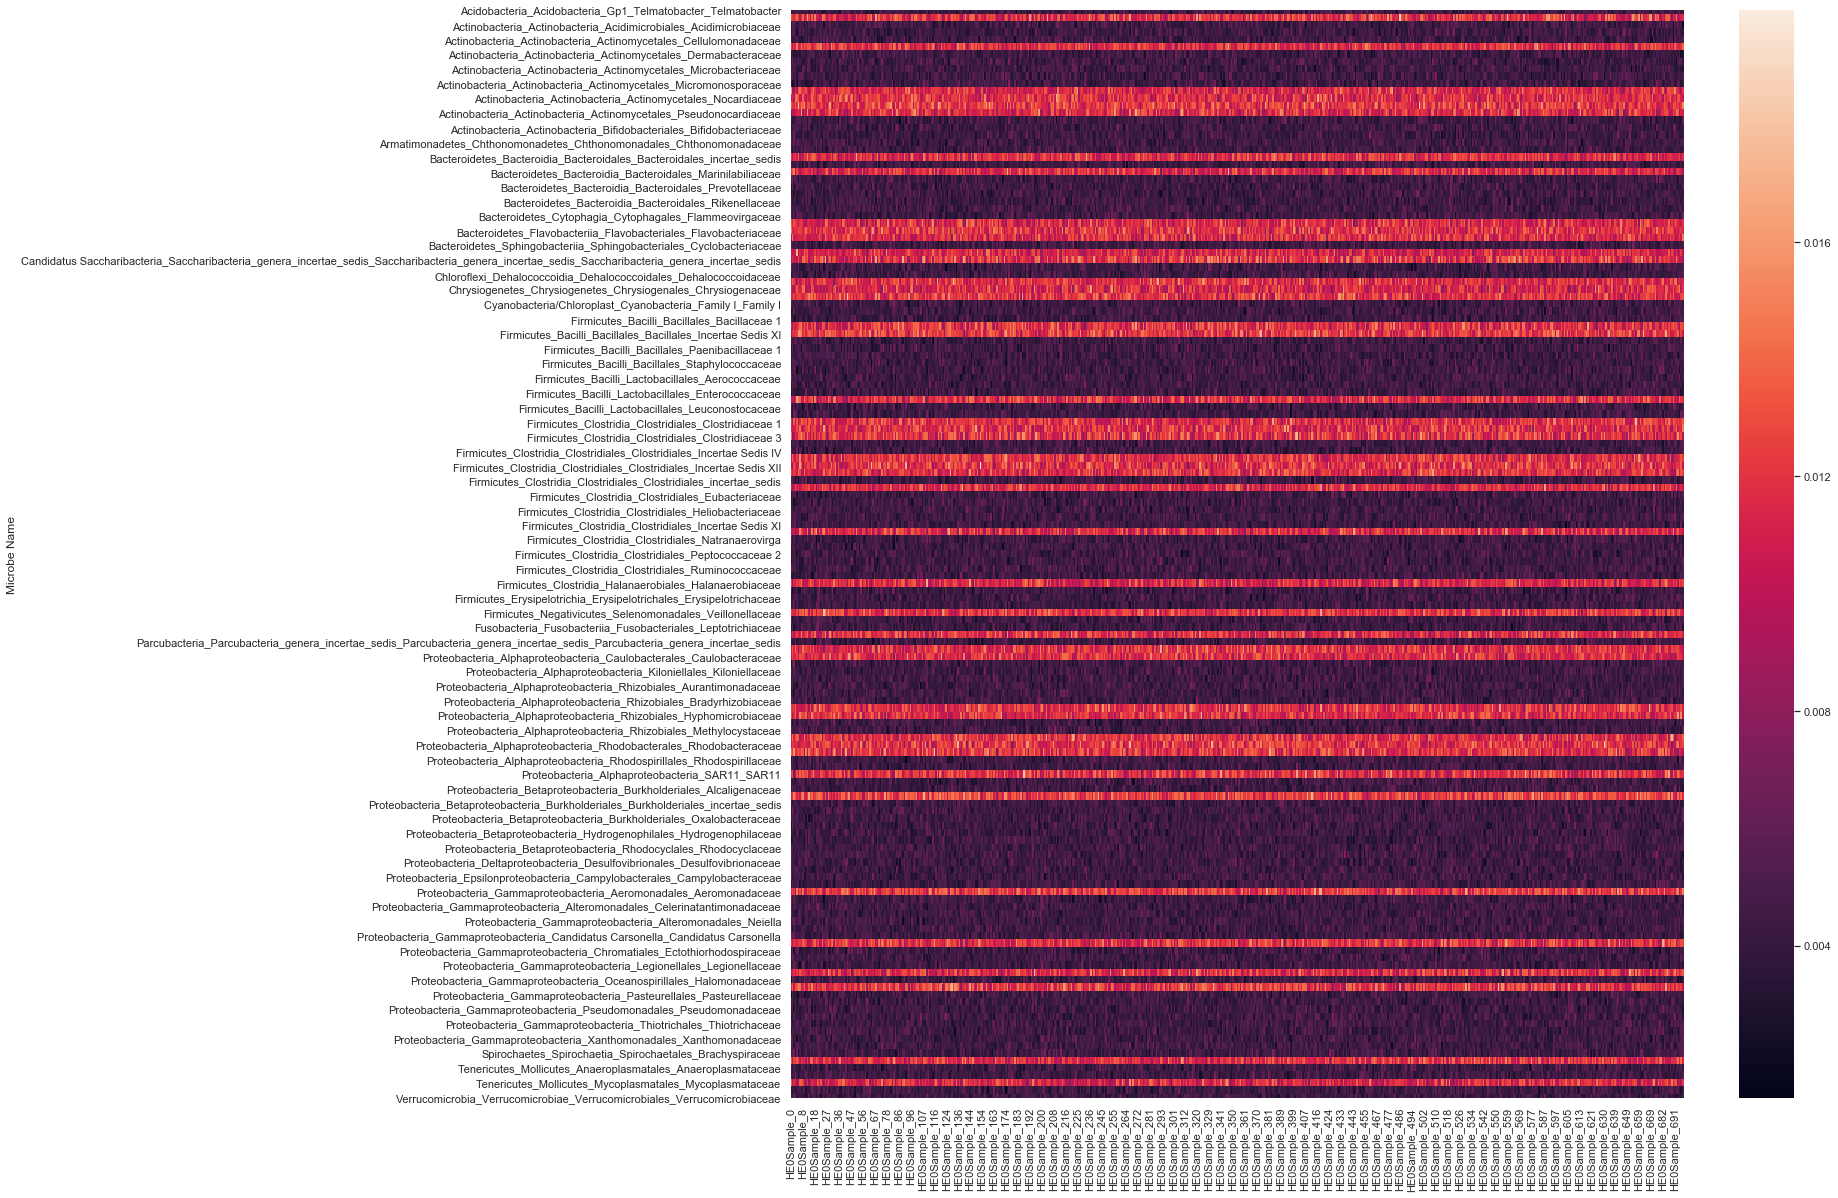

In [23]:
# plot the heatmap for HE0
print('Heatmap for HE0')
plt.figure(figsize=(20,20))
sns.heatmap(data_gn_HE0)
plt.savefig('heatmap_for_HE0.pdf')
plt.show()

Heatmap for HE1


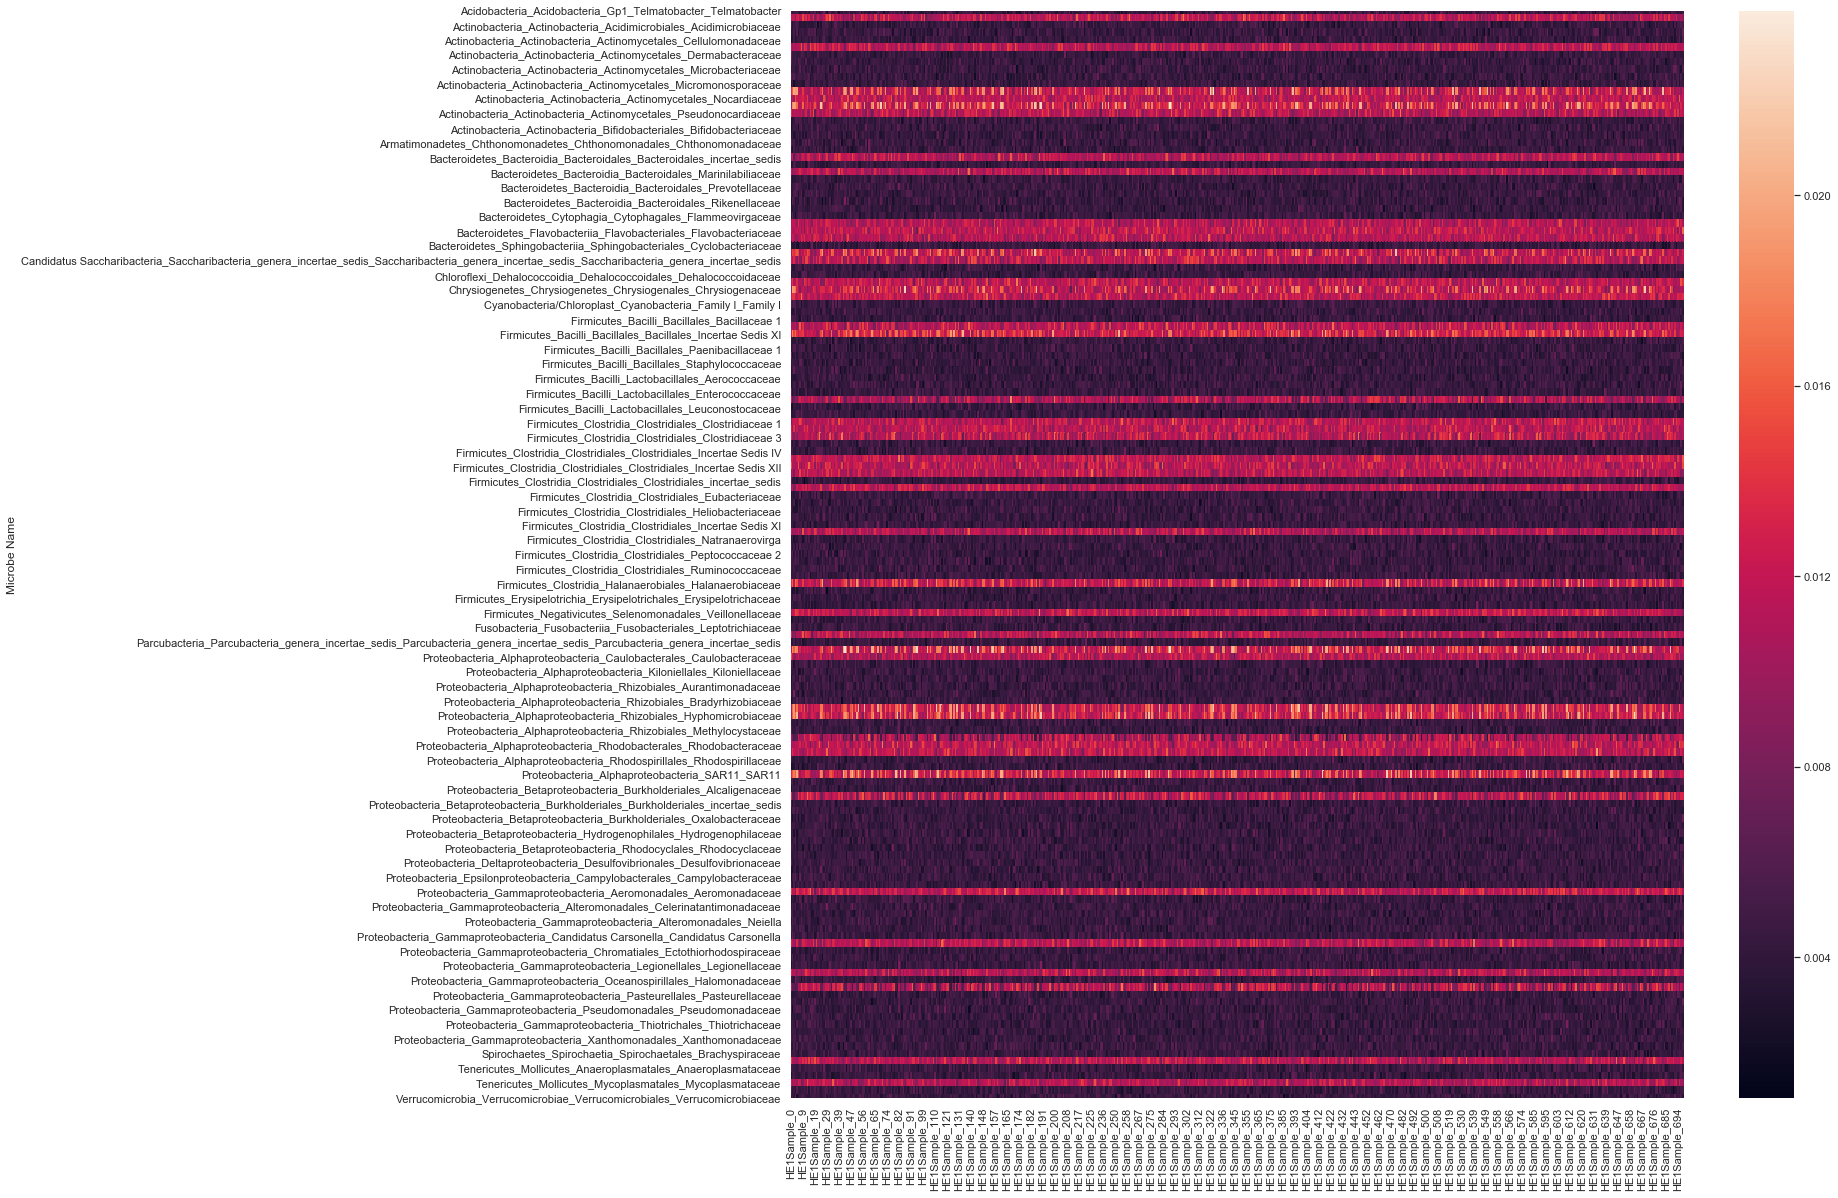

In [24]:
# plot the heatmap for HE1
print('Heatmap for HE1')
plt.figure(figsize=(20,20))
sns.heatmap(data_gn_HE1)
plt.savefig('heatmap_for_HE1.pdf')
plt.show()

$
\textbf{Observation:}\\
\text{To be honest, these two heatmaps seem similar to each other for human eyes, except that the heatmap for HE0}\\ 
\text{samples seems brighter than that for HE1 samples, or, in other words, that color comparison is stronger in}\\  
\text{the heatmap for HE0 samples than in that for HE1 samples. That's to say, the relatively abundant microbes in}\\  
\text{HE0 samples take up larger proportions respectively than their counterparts in HE1 samples do, and the relatively}\\  
\text{less microbes in HE0 samples take up smaller proportions respectively than their counterparts in HE1 samples do.}\\ 
\ \\
\text{The heatmaps are good at highlighting the data that have relatively large values and the difference between the data}\\  
\text{that have different values. In our context, the heatmaps are good at highlighting the relatively abundant microbes}\\  
\text{in HE0 or HE1 samples.}\\  
\ \\
\text{The heatmaps are less suitable for analyzing networks or hierarchical relationships, because these types of things are}\\  
\text{irrelevant to the values of data.}\\ 
$

# Task 2: Statistical Analysis

## 1. Kolmogorov-Smirnov (KS) Test

### a. p-value for Two-Sample KS Test

In [25]:
# find the p-value of a two-sample KS test on its expression across HE0 samples vs. HE1 samples
st_value_list = []
p_value_list = []
micro_list = []
for i in range(data_gn_HE0.shape[0]):#use for loop to iterate all microbe rows and build the D and p value dictionary 
    HE0_dis=np.array(data_gn_HE0.iloc[i])
    HE1_dis=np.array(data_gn_HE1.iloc[i])
    st_value,p_value = st.ks_2samp(HE0_dis,  HE1_dis)
    micro_list.append(data_gn_HE0.index[i])
    st_value_list.append(st_value)#build the list for iteration to check for alert
    p_value_list.append(p_value)
    
micro_dict_HE0 = pd.DataFrame({"Microbe": micro_list, "P-value": p_value_list})
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth',200)
micro_dict_HE0

Microbe  \
0                                                                                         Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter   
1                                                                                                             Acidobacteria_Acidobacteria_Gp3_Gp3_Gp3   
2                                                                                    Actinobacteria_Actinobacteria_Acidimicrobiales_Acidimicrobiaceae   
3                                                                                      Actinobacteria_Actinobacteria_Actinomycetales_Actinomycetaceae   
4                                                                                     Actinobacteria_Actinobacteria_Actinomycetales_Cellulomonadaceae   
5                                                                                    Actinobacteria_Actinobacteria_Actinomycetales_Corynebacteriaceae   
6                                                                                      Actinobacteria_Actinobacteria_Actinomycetales_Dermabacteraceae   
7                                                                                   Actinobacteria_Actinobacteria_Actinomycetales_Geodermatophilaceae   
8                                                                                     Actinobacteria_Actinobacteria_Actinomycetales_Microbacteriaceae   
9                                                                                        Actinobacteria_Actinobacteria_Actinomycetales_Micrococcaceae   
10                                                                                   Actinobacteria_Actinobacteria_Actinomycetales_Micromonosporaceae   
11                                                                                      Actinobacteria_Actinobacteria_Actinomycetales_Nakamurellaceae   
12                                                                                         Actinobacteria_Actinobacteria_Actinomycetales_Nocardiaceae   
13                                                                                 Actinobacteria_Actinobacteria_Actinomycetales_Propionibacteriaceae   
14                                                                                   Actinobacteria_Actinobacteria_Actinomycetales_Pseudonocardiaceae   
15                                                                                    Actinobacteria_Actinobacteria_Actinomycetales_Sanguibacteraceae   
16                                                                                 Actinobacteria_Actinobacteria_Bifidobacteriales_Bifidobacteriaceae   
17                                                                                   Actinobacteria_Actinobacteria_Coriobacteriales_Coriobacteriaceae   
18                                                                                Armatimonadetes_Chthonomonadetes_Chthonomonadales_Chthonomonadaceae   
19                                                                                             Bacteroidetes_Bacteroidia_Bacteroidales_Bacteroidaceae   
20                                                                               Bacteroidetes_Bacteroidia_Bacteroidales_Bacteroidales_incertae_sedis   
21                                                                                            Bacteroidetes_Bacteroidia_Bacteroidales_Marinilabiaceae   
22                                                                                          Bacteroidetes_Bacteroidia_Bacteroidales_Marinilabiliaceae   
23                                                                                         Bacteroidetes_Bacteroidia_Bacteroidales_Porphyromonadaceae   
24                                                                                             Bacteroidetes_Bacteroidia_Bacteroidales_Prevotellaceae   
25                                                                                         Bacteroidetes_Bacteroidia_Bacteroidales_Prolixibacteraceae   
26         

### b. Null Hypothesis of the KS Test in our Context

$
\textbf{Null hypothesis:}\\
\text{The distribution of the relative abundance of a certain microbe in HE0 samples is the same as}\\
\text{the distribution of the relative abundance of that kind of microbe in HE1 samples.}\\
\ \\
\textbf{Example:}\ \text{Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter}
\\
\text{The null hypothesis is that the distribution of the relative abundance of Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter}\\
\text{in HE0 samples is the same as the distribution of the relative abundance of Acidobacteria_Acidobacteria_Gp1_Telmatobacter_Telmatobacter}\\ 
\text{in HE1 samples.}
$

### c. Number of Genes with Significantly Altered Expression at Various Alpha Values

In [26]:
alpha_list=[0.1,0.05,0.01,0.005,0.001]
num_alerts=[]
for alpha in alpha_list:
    num_alert=0
    for p_value in p_value_list:# iterate the p_value_list to check how many micorbe satisfy the given alpha
        if p_value < alpha :# if smaller than alpha =>reject the null hypothesis 
            num_alert+=1
    num_alerts.append(num_alert) # create the dictionary for the alert at given alpha

alert_dataframe_table = pd.DataFrame({"𝛼":alpha_list, '# of microbes with altered expression': num_alerts})

alert_dataframe_table

𝛼  # of microbes with altered expression
0  0.100                                     42
1  0.050                                     36
2  0.010                                     27
3  0.005                                     26
4  0.001                                     21

## 2. Multiple Testing

### a. P-value

$
\text{A p-value of 0.05 in our context represents that the probability of the observed or less similarity between the distribution}\\
\text{of the relative abundance of a certain microbe in HE0 samples and the distribution of the relative abundance of that kind of}\\
\text{microbe in HE1 samples is 0.05, given that the null hypothesis is true.}
$

### b. P-value Distribution

$
\text{The p-values follow uniform distribution in [0,1].}
$

### c. Expected Number of Significant p-values

In [27]:
ex_alert=[]
total_microbe_number=data_gn_HE0.shape[0]
for alpha in alpha_list:
    signif_p_num=total_microbe_number*alpha# if p is the uniform distribution the significant microbe number 
                                           #should equal to the total_microbe_number*alpha
        
    # NOTE: we round the expected number of microbes with altered expression to an integer
    # to meet our intuition that the number of microbes should be an integer
    ex_alert.append(signif_p_num)

#add a new column to the outside dict 
#this can add a new column in the table
#make sure you run the former cell to get the right compare table
compare_alert_table = pd.DataFrame({"𝛼":alpha_list, 'Observed # of microbes with altered expression': num_alerts, 
                                    "Expected # of microbes with altered expression": ex_alert})
compare_alert_table

𝛼  Observed # of microbes with altered expression  \
0  0.100                                              42   
1  0.050                                              36   
2  0.010                                              27   
3  0.005                                              26   
4  0.001                                              21   

   Expected # of microbes with altered expression  
0                                          14.900  
1                                           7.450  
2                                           1.490  
3                                           0.745  
4                                           0.149

$
\text{From the comparision table, we find that as $\alpha$ goes larger the ratio between the observed number of microbes with}\\
\text{altered expression and the expected number of microbes with altered expression becomes closer to 1 and that both the}\\
\text{observed and expected numbers increase as $\alpha$ increases.}
$

### d. Q-Q plot of p-values

#### i. 

In [28]:
# Sample N values from the expected distribution
N = len(p_value_list)
# choose the N that is the same with the observed p_value size
uniform_p=st.uniform()
p_samples=uniform_p.rvs(size=N)

#### ii. 

In [29]:
# Take the -log10() of observed p-values and expected p-values
log_p_observe=-np.log10(p_value_list)
log_p_expected=-np.log10(p_samples)

#### iii. 

In [30]:
# Rank observed p-values and expected p-values in ascending order separately
log_p_observe.sort()
log_p_expected.sort()

#### iv. v. vi.

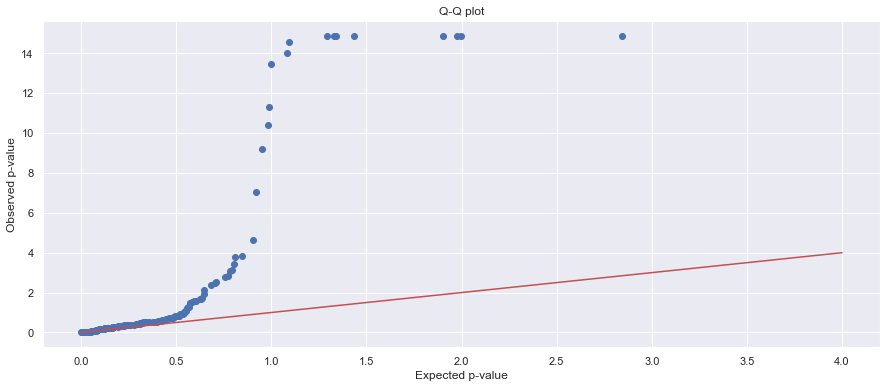

In [31]:
# iv. v.
plt.figure(figsize=(15,6))#print dots
for i in range(len(log_p_expected)):
    plt.plot(log_p_expected[i],log_p_observe[i],'bo')
    
# vi.
x_line=np.linspace(0,4,3001)#print line
y_line=np.linspace(0,4,3001)
plt.plot(x_line,y_line,'r')

# plot formating
plt.xlabel('Expected p-value')
plt.ylabel('Observed p-value')
plt.title('Q-Q plot')
plt.savefig('Q_Q_plot.png')
plt.show()

### e. Follow-up Questions

#### i. 

$
\text{The –log10() maps the original p-values from a smaller range [0,1] to a much larger range [0, +∞], which enlarges}\\
\text{the difference between p-values, helping us visualize the distribution of dots in the graph and see the deviation}\\
\text{between the dots and the y=x line.}
$

#### ii. 

$
\text{From the Q-Q plot, it is easy to observe that expected p-values are really close to observed p-values when p-values}\\
\text{are larger than approximately $10^{-0.4}$, which is $0.3981071705534972$. Besides, observed p-values are smaller than}\\
\text{expected p-values when p-values are smaller than approximately $10^{-0.4}$, which is $0.3981071705534972$, and the gap}\\
\text{between observed p-values and expected p-values increases as p-values become smaller. That's to say, observed p-values}\\
\text{have similar tendency as expected p-values have to fail to reject the null hypothesis when they are large, since they}\\
\text{are close to each other. However, observed p-values have larger tendency than expected p-values have to reject the null}\\
\text{hypothesis when they are small, because the observed p-values are smaller than expected p-values and the gap between}\\
\text{them increases as they become smaller. To conclude, the observed p-value distribution has larger overall tendency to}\\
\text{reject the null hypothesis than the expected p-value distribution has.}
$

# Task 3: Dimensionality Reduction and Clustering

## 1. PCA

### a. Performing PCA

In [32]:
# get the data
PCA_data_HE0 = []
PCA_data_HE1 = []

for i in range(data_gn_HE0.shape[1]):
    PCA_data_HE0.append(np.array(data_gn_HE0.iloc[:,i]))
    
for i in range(data_gn_HE1.shape[1]):
    PCA_data_HE1.append(np.array(data_gn_HE1.iloc[:,i]))
    
PCA_data_HE0 = np.array(PCA_data_HE0)
PCA_data_HE1 = np.array(PCA_data_HE1)

In [33]:
# apply PCA to HE0 samples
PCA_HE0 = PCA(n_components = PCA_data_HE0.shape[1], svd_solver = "full")
PCA_HE0.fit(PCA_data_HE0)
pdataHE0 = PCA_HE0.transform(PCA_data_HE0)

# apply PCA to HE1 samples
PCA_HE1 = PCA(n_components = PCA_data_HE1.shape[1], svd_solver = "full")
PCA_HE1.fit(PCA_data_HE1)
pdataHE1 = PCA_HE1.transform(PCA_data_HE1)


### b. Ordering Components

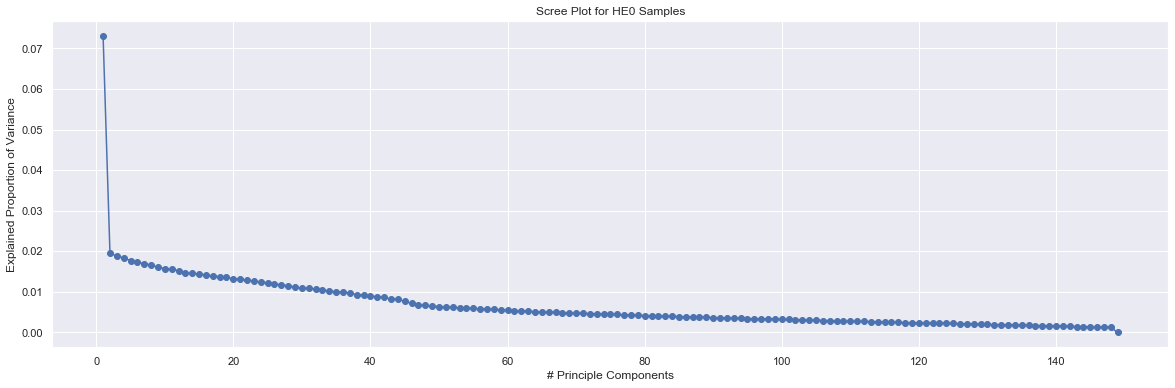

The number of principal components needed to explain 30% of the total variance for HE0 samples: 15


In [34]:
# sort PAs with normallized variance for HE0 samples
PA0_sort_by_var = PCA_HE0.explained_variance_ratio_

# generate the points and plot the scree plot for HE0 samples
plt.figure(figsize=(20,6))

for i in range(PCA_HE0.n_components_):
    if(0.3 <= sum(PA0_sort_by_var[:i+1])):
        num_HE0 = i + 1
        break
        
plt.plot([i for i in range(1,PCA_HE0.n_components_+1)],PA0_sort_by_var,"bo-")

# plot formating
plt.xlabel('# Principle Components')
plt.ylabel('Explained Proportion of Variance')
plt.title('Scree Plot for HE0 Samples')
plt.show()

print("The number of principal components needed to explain 30% of the total variance for HE0 samples:", num_HE0)

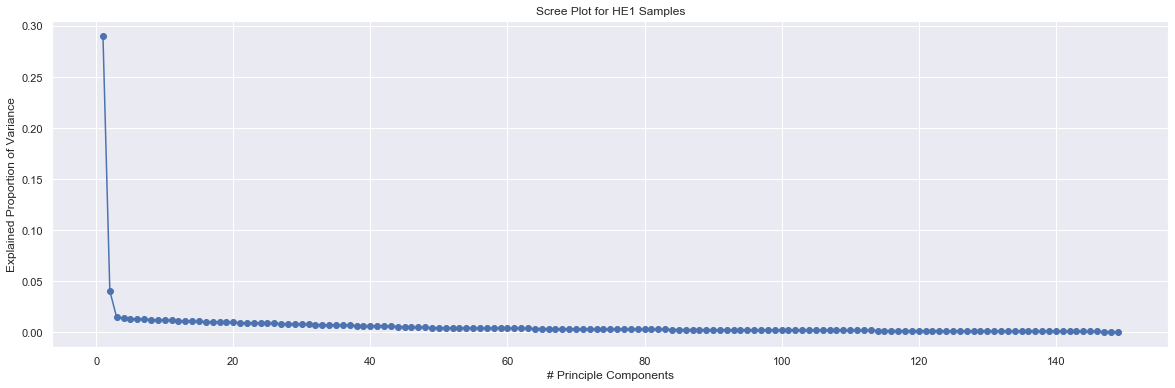

The number of principal components needed to explain 30% of the total variance for HE1 samples: 2


In [35]:
# sort PAs with normallized variance for HE1 samples
PA1_sort_by_var = PCA_HE1.explained_variance_ratio_

# generate the points and plot the scree plot for HE1 samples
plt.figure(figsize=(20,6))

for i in range(PCA_HE1.n_components_):
    if(0.3 <= sum(PA1_sort_by_var[:i+1])):
        num_HE1 = i + 1
        break
        
plt.plot([i for i in range(1,PCA_HE1.n_components_+1)],PA1_sort_by_var,"bo-")

# plot formating
plt.xlabel('# Principle Components')
plt.ylabel('Explained Proportion of Variance')
plt.title('Scree Plot for HE1 Samples')
plt.show()

print("The number of principal components needed to explain 30% of the total variance for HE1 samples:", num_HE1)

### c. Scatter Plot of Microbe Abundance

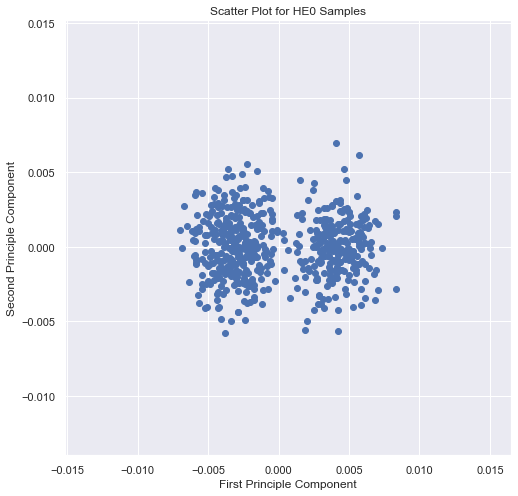

In [36]:
#generate scatter plot for HE0 samples
plt.figure(figsize=(8,8))
plt.scatter(pdataHE0[:,0], pdataHE0[:,1])
# plot formating
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component')
plt.title('Scatter Plot for HE0 Samples')
plt.show()

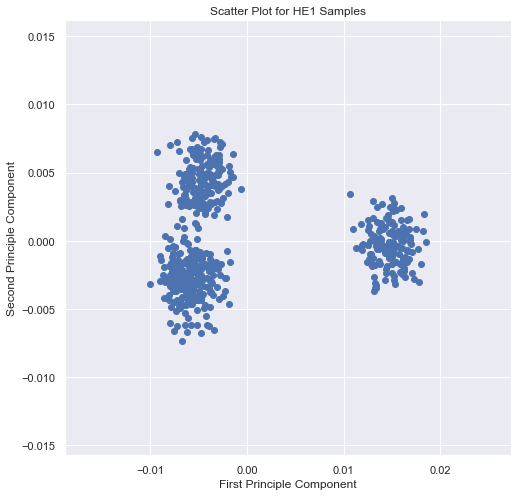

In [37]:
#generate scatter plot for HE1 samples
plt.figure(figsize=(8,8))
plt.scatter(pdataHE1[:,0], pdataHE1[:,1])
# plot formating
plt.xlabel('First Principle Component')
plt.ylabel('Second Principle Component')
plt.title('Scatter Plot for HE1 Samples')
plt.show()

$
\text{It seems that there are two clusters in the HE0 samples while three clusters in the HE1 samples. Besides,}\\
\text{the distance between the right cluster and the left cluster/clusters along the first principle component}\\
\text{in HE1 samples is larger than that in HE0 samples.}
$

## 2. t-SNE

### a. Performing t-SNE

In [38]:
# get the data
t_SNE_data_HE0 = []
t_SNE_data_HE1 = []

for i in range(data_gn_HE0.shape[1]):
    t_SNE_data_HE0.append(np.array(data_gn_HE0.iloc[:,i]))
    
for i in range(data_gn_HE1.shape[1]):
    t_SNE_data_HE1.append(np.array(data_gn_HE1.iloc[:,i]))
    
t_SNE_data_HE0 = np.array(t_SNE_data_HE0)
t_SNE_data_HE1 = np.array(t_SNE_data_HE1)

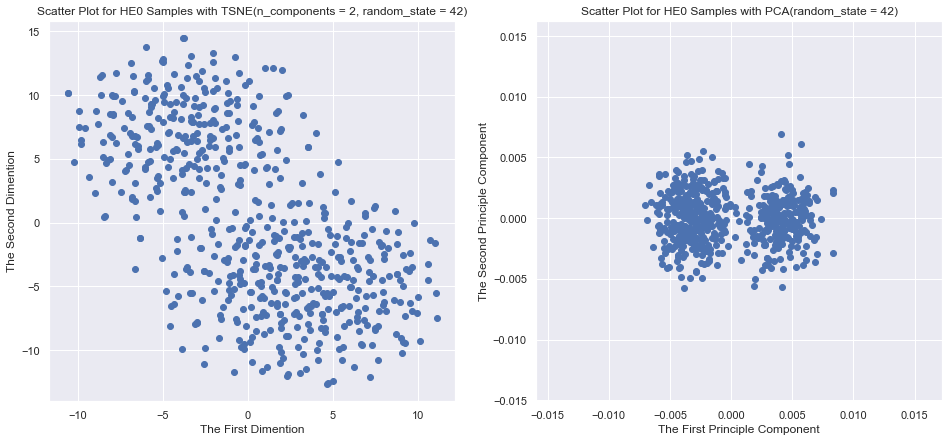

In [39]:
# t-SNE and PCA for HE0 set with random_state equaling 42

# apply t-SNE to HE0 samples
tsne_HE0 = TSNE(n_components = 2, random_state = 42).fit_transform(t_SNE_data_HE0)
# apply PCA to HE0 samples
pca_HE0 = PCA(random_state = 42).fit_transform(t_SNE_data_HE0)

plt.figure(figsize=(16, 7))

plt.subplot(121)
plt.scatter(tsne_HE0[:,0], tsne_HE0[:,1])

# plot formating
plt.xlabel('The First Dimention')
plt.ylabel('The Second Dimention')
plt.title('Scatter Plot for HE0 Samples with TSNE(n_components = 2, random_state = 42)')

plt.subplot(122)
plt.scatter(pca_HE0[:,0], pca_HE0[:,1])

# plot formating
plt.xlabel('The First Principle Component')
plt.ylabel('The Second Principle Component')
plt.title('Scatter Plot for HE0 Samples with PCA(random_state = 42)')

plt.show()

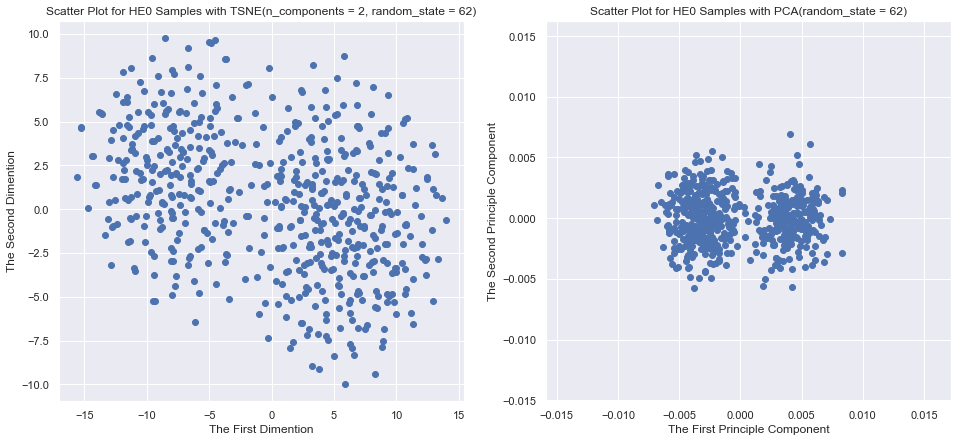

In [40]:
# t-SNE and PCA for HE0 set with random_state equaling 62

# apply t-SNE to HE0 samples
tsne_HE0 = TSNE(n_components = 2, random_state = 62).fit_transform(t_SNE_data_HE0)
# apply PCA to HE0 samples
pca_HE0 = PCA(random_state = 62).fit_transform(t_SNE_data_HE0)

plt.figure(figsize=(16, 7))

plt.subplot(121)
plt.scatter(tsne_HE0[:,0], tsne_HE0[:,1])

# plot formating
plt.xlabel('The First Dimention')
plt.ylabel('The Second Dimention')
plt.title('Scatter Plot for HE0 Samples with TSNE(n_components = 2, random_state = 62)')

plt.subplot(122)
plt.scatter(pca_HE0[:,0], pca_HE0[:,1])

# plot formating
plt.xlabel('The First Principle Component')
plt.ylabel('The Second Principle Component')
plt.title('Scatter Plot for HE0 Samples with PCA(random_state = 62)')

plt.show()

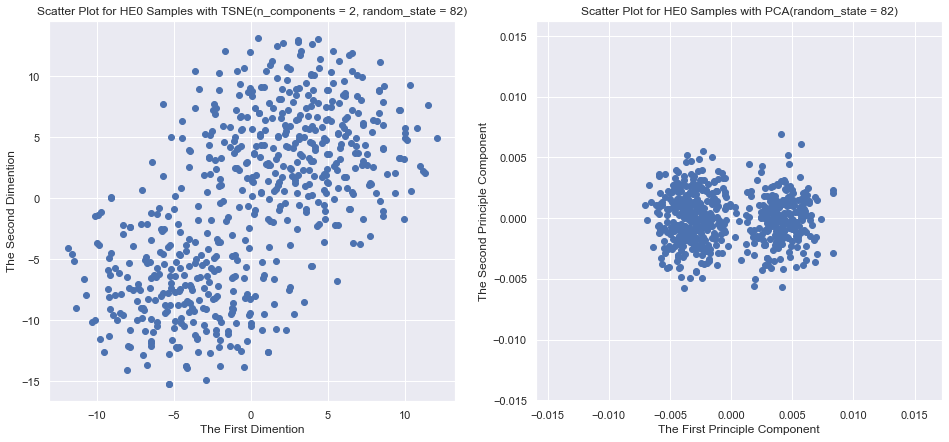

In [41]:
# t-SNE and PCA for HE0 set with random_state equaling 82

# apply t-SNE to HE0 samples
tsne_HE0 = TSNE(n_components = 2, random_state = 82).fit_transform(t_SNE_data_HE0)
# apply PCA to HE0 samples
pca_HE0 = PCA(random_state = 82).fit_transform(t_SNE_data_HE0)

plt.figure(figsize=(16, 7))

plt.subplot(121)
plt.scatter(tsne_HE0[:,0], tsne_HE0[:,1])

# plot formating
plt.xlabel('The First Dimention')
plt.ylabel('The Second Dimention')
plt.title('Scatter Plot for HE0 Samples with TSNE(n_components = 2, random_state = 82)')

plt.subplot(122)
plt.scatter(pca_HE0[:,0], pca_HE0[:,1])

# plot formating
plt.xlabel('The First Principle Component')
plt.ylabel('The Second Principle Component')
plt.title('Scatter Plot for HE0 Samples with PCA(random_state = 82)')

plt.show()

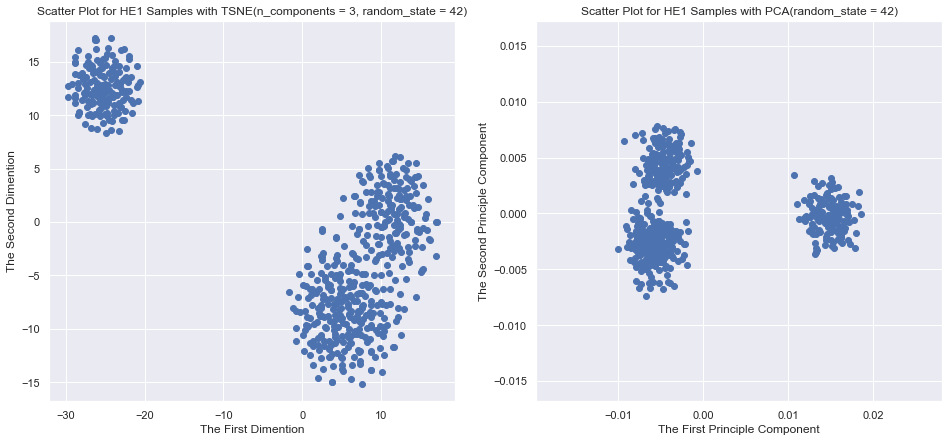

In [42]:
# t-SNE and PCA for HE1 set with random_state equaling 42

# apply t-SNE to HE1 samples
tsne_HE1 = TSNE(n_components = 2, random_state = 42).fit_transform(t_SNE_data_HE1)
# apply PCA to HE1 samples
pca_HE1 = PCA(random_state = 42).fit_transform(t_SNE_data_HE1)

plt.figure(figsize=(16, 7))

plt.subplot(121)
plt.scatter(tsne_HE1[:,0], tsne_HE1[:,1])

# plot formating
plt.xlabel('The First Dimention')
plt.ylabel('The Second Dimention')
plt.title('Scatter Plot for HE1 Samples with TSNE(n_components = 3, random_state = 42)')

plt.subplot(122)
plt.scatter(pca_HE1[:,0], pca_HE1[:,1])

# plot formating
plt.xlabel('The First Principle Component')
plt.ylabel('The Second Principle Component')
plt.title('Scatter Plot for HE1 Samples with PCA(random_state = 42)')

plt.show()

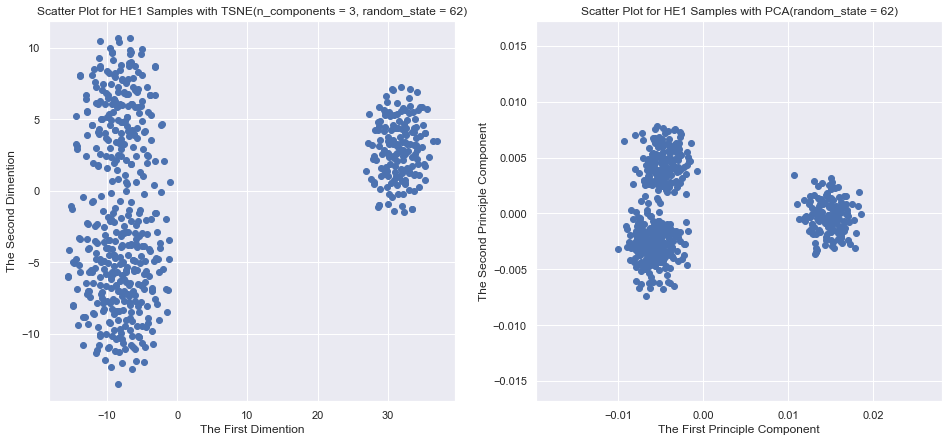

In [43]:
# t-SNE and PCA for HE1 set with random_state equaling 62

# apply t-SNE to HE1 samples
tsne_HE1 = TSNE(n_components = 2, random_state = 62).fit_transform(t_SNE_data_HE1)
# apply PCA to HE1 samples
pca_HE1 = PCA(random_state = 62).fit_transform(t_SNE_data_HE1)

plt.figure(figsize=(16, 7))

plt.subplot(121)
plt.scatter(tsne_HE1[:,0], tsne_HE1[:,1])

# plot formating
plt.xlabel('The First Dimention')
plt.ylabel('The Second Dimention')
plt.title('Scatter Plot for HE1 Samples with TSNE(n_components = 3, random_state = 62)')

plt.subplot(122)
plt.scatter(pca_HE1[:,0], pca_HE1[:,1])

# plot formating
plt.xlabel('The First Principle Component')
plt.ylabel('The Second Principle Component')
plt.title('Scatter Plot for HE1 Samples with PCA(random_state = 62)')

plt.show()

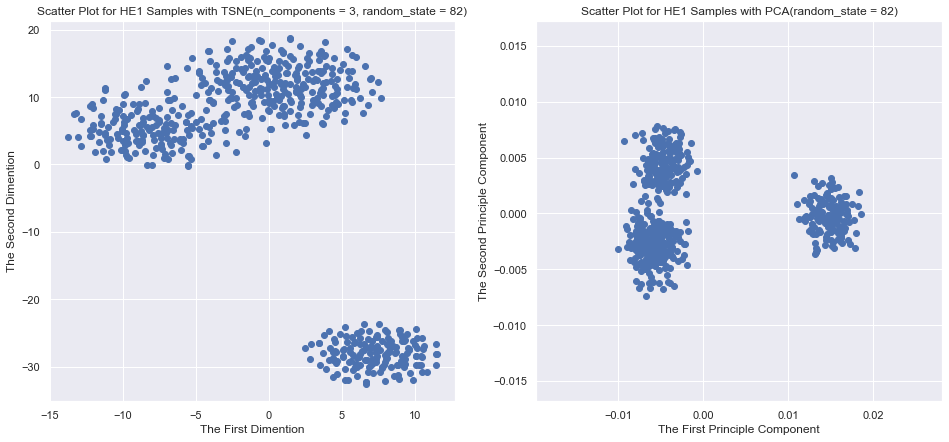

In [44]:
# t-SNE and PCA for HE1 set with random_state equaling 82

# apply t-SNE to HE1 samples
tsne_HE1 = TSNE(n_components = 2, random_state = 82).fit_transform(t_SNE_data_HE1)
# apply PCA to HE1 samples
pca_HE1 = PCA(random_state = 82).fit_transform(t_SNE_data_HE1)

plt.figure(figsize=(16, 7))

plt.subplot(121)
plt.scatter(tsne_HE1[:,0], tsne_HE1[:,1])

# plot formating
plt.xlabel('The First Dimention')
plt.ylabel('The Second Dimention')
plt.title('Scatter Plot for HE1 Samples with TSNE(n_components = 3, random_state = 82)')

plt.subplot(122)
plt.scatter(pca_HE1[:,0], pca_HE1[:,1])

# plot formating
plt.xlabel('The First Principle Component')
plt.ylabel('The Second Principle Component')
plt.title('Scatter Plot for HE1 Samples with PCA(random_state = 82)')

plt.show()

$
\text{No mater what the value of the random_state parameter is, there tends to be two clusters in the result}\\
\text{derived by the t-SNE method for the HE0 samples, which is consistent with the result derived by the PCA}\\ 
\text{method for the HE0 samples. By contrast, no mater what the value of the random_state parameter is, there}\\ 
\text{tends to be three clusters in the result derived by the t-SNE method for the HE1 samples, which is also}\\ 
\text{consistent with the result derived by the PCA method for the HE1 samples. In addition, the results derived}\\ 
\text{by the PCA method are independent of the value of the random_state parameter, no matter for the HE0 or HE1}\\ 
\text{samples. However, the results derived by the t-SNE method vary with the value of the random_state parameter,}\\ 
\text{no matter for the HE0 or HE1 samples.}
$

### b. Comparing with PCA

$
\textbf{Similarity:}\\
\text{Both the two methods can reduce the high dimensional data to 2D and keep the inner relationship of the}\\
\text{data. Besides, both the two methods tend to divide the HE0 samples into two clusters while the HE1}\\ 
\text{samples into three clusters.}\\
\textbf{Difference:}\\
\text{1) The results from the PCA method are not affected by the value of the random_state parameter while}\\
\text{the results from the t-SNE method are affected by the value of the random_state parameter.}\\
\text{2) Points in each cluster in the results from the PCA method are much closer to each other than those}\\
\text{in each cluster in the results from the t-SNE method, which may come from that the results from the PCA}\\
\text{method still use the same magnitude as the original data do while the t-SNE method uses larger magnitude}\\
\text{to present its results. Remaining the magnitude of the original data, the PCA may cause the Crowding}\\ 
\text{Problem, because it maps so many high dimentional data points to a 2D space limited by small magnitude.}\\
\text{By contrast, the t-SNE method somehow increases the magnitude, so it enlarges the distance between the}\\ 
\text{data points projected onto the 2D space, which may avoid the Crowding Problem.}
$

## 3. Clustering

### a. K-Means

$
\text{By intuition and inspection of the PCA graph, we can shrink the range of k for HE0, HE1 to [2,6].}
$

In [45]:
# analysis of the cluster number for K-means
Kmeans_HE0_result=[]#store the clustering result 
Kmeans_HE1_result=[]
Kmeans_HE0_silhouette_score=[]#store the kmeans result score based on the Silhouette Coefficient
Kmeans_HE1_silhouette_score=[]
Kmeans_HE0_CH_score=[]   #store the kmeans result score based on the Calinski-Harabasz Index
Kmeans_HE1_CH_score=[]

for i in range(5):#k=i+2
    y_HE0_pred = KMeans(n_clusters=i+2, random_state=9).fit_predict(pca_HE0)#make the clustering for current k
    y_HE1_pred = KMeans(n_clusters=i+2, random_state=9).fit_predict(pca_HE1)
    Kmeans_HE0_result.append(y_HE0_pred)
    Kmeans_HE1_result.append(y_HE1_pred)
    HE0_s_grade=metrics.silhouette_score(pca_HE0, y_HE0_pred)  #get the silhouette_score for current k
    HE1_s_grade=metrics.silhouette_score(pca_HE1, y_HE1_pred)
    HE0_CH_grade=metrics.calinski_harabasz_score(pca_HE0, y_HE0_pred) #get the Calinski-Harabasz_score for current k
    HE1_CH_grade=metrics.calinski_harabasz_score(pca_HE1, y_HE1_pred)
    Kmeans_HE0_silhouette_score.append(HE0_s_grade)
    Kmeans_HE1_silhouette_score.append(HE1_s_grade)
    Kmeans_HE0_CH_score.append(HE0_CH_grade)
    Kmeans_HE1_CH_score.append(HE1_CH_grade)

In [46]:
# analysis result
for i in range(5):
    print("HE0: k={},  silhouette score={}, Calinski-Harabasz score={}\n".format(i+2,Kmeans_HE0_silhouette_score[i],Kmeans_HE0_CH_score[i]))
for i in range(5):    
    print("HE1: k={},  silhouette score={}, Calinski-Harabasz score={}\n".format(i+2,Kmeans_HE1_silhouette_score[i],Kmeans_HE1_CH_score[i]))

HE0: k=2,  silhouette score=0.062364532980205584, Calinski-Harabasz score=40.18006251165129

HE0: k=3,  silhouette score=0.025289444084550108, Calinski-Harabasz score=23.045045815362112

HE0: k=4,  silhouette score=0.01237878909148934, Calinski-Harabasz score=16.848825205975746

HE0: k=5,  silhouette score=0.01032583707865406, Calinski-Harabasz score=13.645941451672838

HE0: k=6,  silhouette score=0.011055576271412133, Calinski-Harabasz score=11.72190030177498

HE1: k=2,  silhouette score=0.28789834430461986, Calinski-Harabasz score=232.926741809354

HE1: k=3,  silhouette score=0.12734698600230596, Calinski-Harabasz score=136.70142611733652

HE1: k=4,  silhouette score=0.09970625326687824, Calinski-Harabasz score=93.1443307813237

HE1: k=5,  silhouette score=0.08989094995737447, Calinski-Harabasz score=71.13252852045044

HE1: k=6,  silhouette score=0.02082007946464085, Calinski-Harabasz score=57.84132261189822



$
\text{We use the Silhouette score and the Calinski-Harabasz score to evaluate our k-means clustering results}\\ 
\text{for different $k$ values. Note that the larger both the scores are, the better the clustering result is.}\\  
\text{We find that the Silhouette score and the Calinski-Harabasz score verify each other. For HE0 samples,}\\  
\text{$k=2$ has the largest Silhouette score and the largest Calinski-Harabasz score.}\\  
\ \\
\text{However, there is potential of overfitting in the HE1 samples if $k=2$, because both the scores for $k=2$}\\  
\text{are relatively too high. From our observation, we see that the HE1 data set after applying PCA is more}\\  
\text{likely to be divided into 3 clusters. Besides, given that "HE1: k=3,  silhouette score=0.12734698600230596,}\\  
\text{Calinski-Harabasz score=136.70142611733658", both the scores are still much better than the scores for the}\\  
\text{remaining $k$ values. Therefore, $k=3$ is also an acceptable cluster value. Based on our observation and analysis,}\\ 
\text{we choose $k$ to be 3 for the HE1 data set after applying PCA.}
$

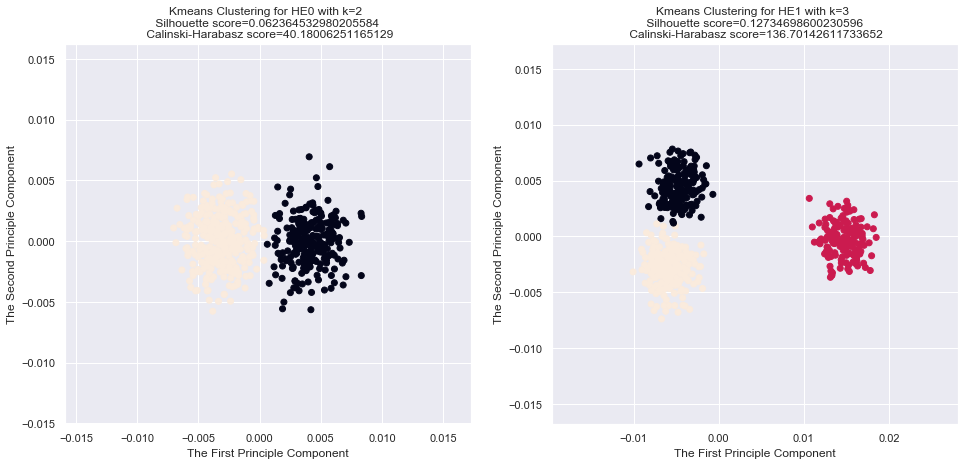

In [47]:
# cluster results from K-means
plt.figure(figsize=(16, 7))
plt.subplot(121)
plt.scatter(pca_HE0[:, 0], pca_HE0[:, 1],c = Kmeans_HE0_result[0])
plt.xlabel('The First Principle Component')
plt.ylabel('The Second Principle Component')
plt.title('Kmeans Clustering for HE0 with k={} \n Silhouette score={} \n Calinski-Harabasz score={}'.format(2,Kmeans_HE0_silhouette_score[0],Kmeans_HE0_CH_score[0]))     

plt.subplot(122)
plt.scatter(pca_HE1[:, 0], pca_HE1[:, 1],c = Kmeans_HE1_result[1])
plt.xlabel('The First Principle Component')
plt.ylabel('The Second Principle Component')
plt.title('Kmeans Clustering for HE1 with k={} \n Silhouette score={} \n Calinski-Harabasz score={}'.format(3,Kmeans_HE1_silhouette_score[1],Kmeans_HE1_CH_score[1]))     

plt.show()

### b. GMM

In [48]:
# apply GMM
GMM_HE0_result=[]#store the GMM clustering result 
GMM_HE1_result=[]
BIC_HE0=[]#store the BIC value for certain k value
BIC_HE1=[]

for i in range(5):#k=i+2
    y_HE0 = GaussianMixture(n_components=i+2, random_state=9)
    y_HE0.fit(pca_HE0)#make the clustering for current k
    y_HE0_pred= GaussianMixture(n_components=i+2, random_state=9).fit_predict(pca_HE0)
    y_HE1 = GaussianMixture(n_components=i+2, random_state=9)
    y_HE1.fit(pca_HE1)
    y_HE1_pred= GaussianMixture(n_components=i+2, random_state=9).fit_predict(pca_HE1)
    GMM_HE0_result.append(y_HE0_pred)
    GMM_HE1_result.append(y_HE1_pred)
    BICvalue_HE0=y_HE0.bic(pca_HE0)
    BICvalue_HE1=y_HE1.bic(pca_HE1)
    BIC_HE0.append( BICvalue_HE0)
    BIC_HE1.append( BICvalue_HE1)

$
\text{By inspection of the PCA graph and the K-means results, we can choose the $k$ to be 2 for HE0 while 3 for HE1.}
$

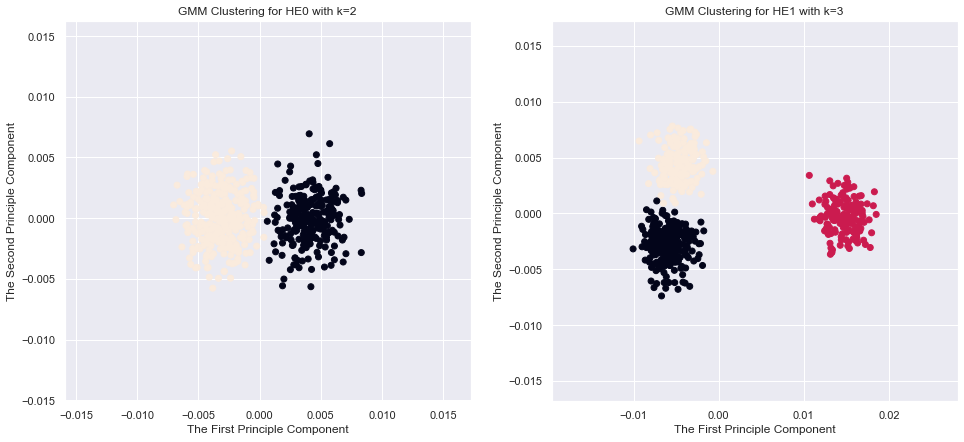

In [49]:
# cluster results from GMM
plt.figure(figsize=(16, 7))
plt.subplot(121)
plt.scatter(pca_HE0[:, 0], pca_HE0[:, 1],c = GMM_HE0_result[0])
plt.xlabel('The First Principle Component')
plt.ylabel('The Second Principle Component')
plt.title('GMM Clustering for HE0 with k={}'.format(2))    

plt.subplot(122)
plt.scatter(pca_HE1[:, 0], pca_HE1[:, 1],c = GMM_HE1_result[1])
plt.xlabel('The First Principle Component')
plt.ylabel('The Second Principle Component')
plt.title('GMM Clustering for HE1 with k={}'.format(3)) 

plt.show()

### c. Single and Complete Linkage Hierarchical

$
\text{By observation on the PCA results, we decide to choose the $k$ to be 2 for HE0 while 3 for HE1.}
$

In [50]:
# data interface
dataH0 = PCA_data_HE0
dataH1 = PCA_data_HE1

pdataH0 = pdataHE0
pdataH1 = pdataHE1

In [51]:
# generate points
hierH0 = []
hierH1 = []
for i in range(len(dataH0)):
    hierH0.append([pdataH0[i, 0], pdataH0[i, 1]])
for i in range(len(dataH1)):
    hierH1.append([pdataH1[i, 0], pdataH1[i, 1]])
#generate cluster
from sklearn.cluster import AgglomerativeClustering
#generate cluster using single linkage Hierarchical clustering
clusH0s = skl.cluster.AgglomerativeClustering(n_clusters=2, linkage = 'single').fit(hierH0)
clusH1s = skl.cluster.AgglomerativeClustering(n_clusters=3, linkage = 'single').fit(hierH1)
#generate cluster using complete linkage Hierarchical clustering
clusH0c = skl.cluster.AgglomerativeClustering(n_clusters=2, linkage = 'complete').fit(hierH0)
clusH1c = skl.cluster.AgglomerativeClustering(n_clusters=3, linkage = 'complete').fit(hierH1)

We decide to use 2 clusters by cutting dendrogram like this:


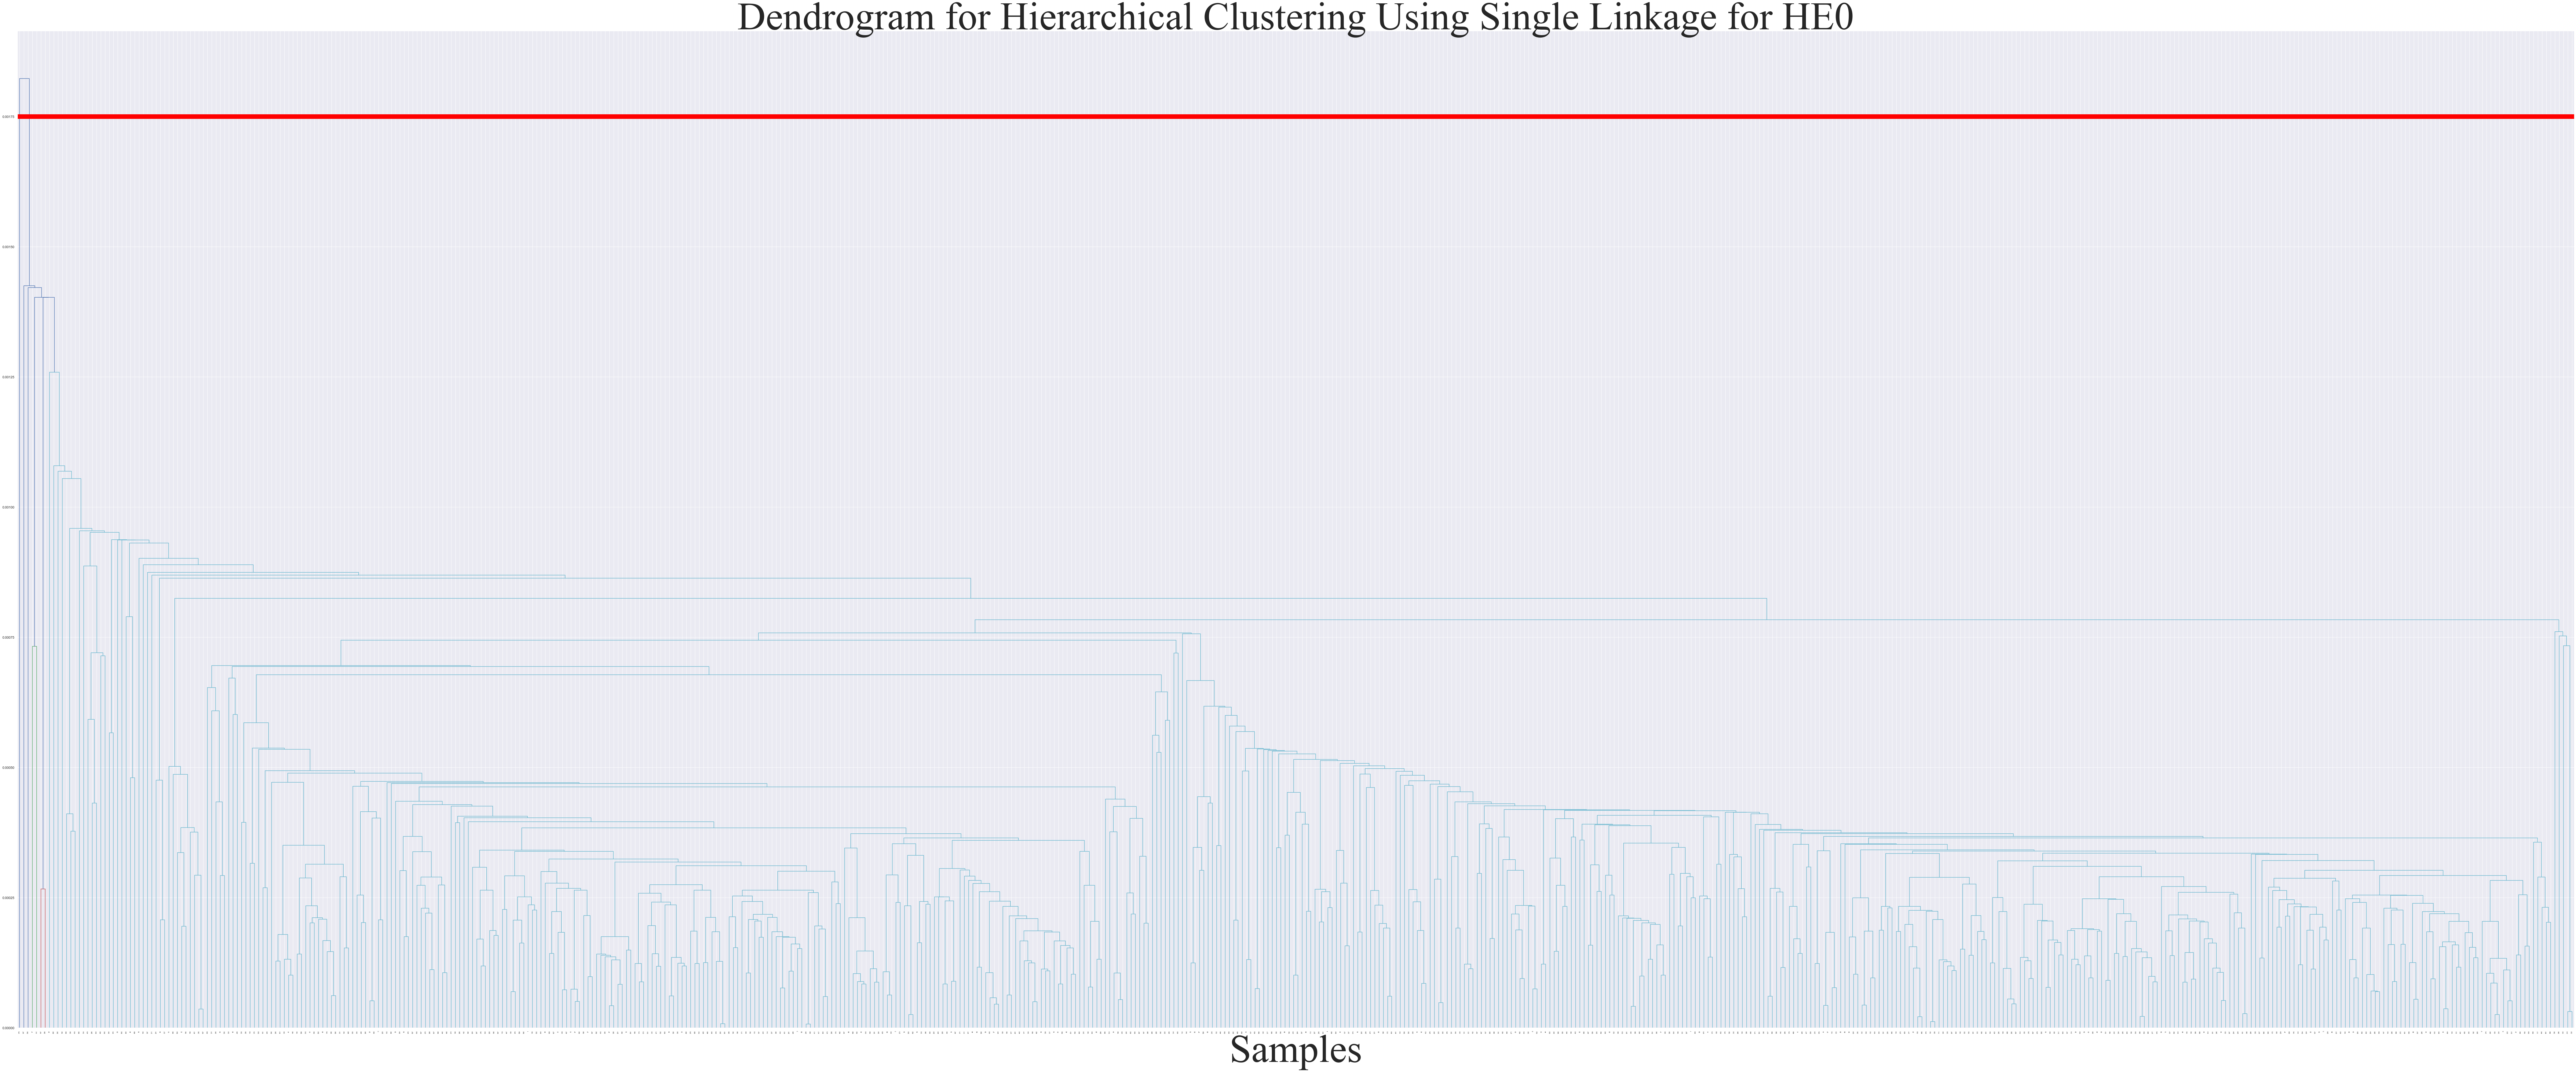

In [52]:
font1 = {'family' : 'Times New Roman',
'weight' : 'normal',
'size'   : 128,
}
from scipy.cluster import hierarchy
# draw dendrogram and decide number of clusters according to its shape
dH0s = plt.figure(figsize=(150,60))
Z = hierarchy.linkage(hierH0, 'single')
hierarchy.dendrogram(Z)
print("We decide to use 2 clusters by cutting dendrogram like this:")
plt.axhline(0.00175, 0, 3,color="red",linewidth = '15')
plt.xlabel('Samples',font1)
plt.title('Dendrogram for Hierarchical Clustering Using Single Linkage for HE0',font1)

plt.show()

We decide to use 2 clusters by cutting dendrogram like this:


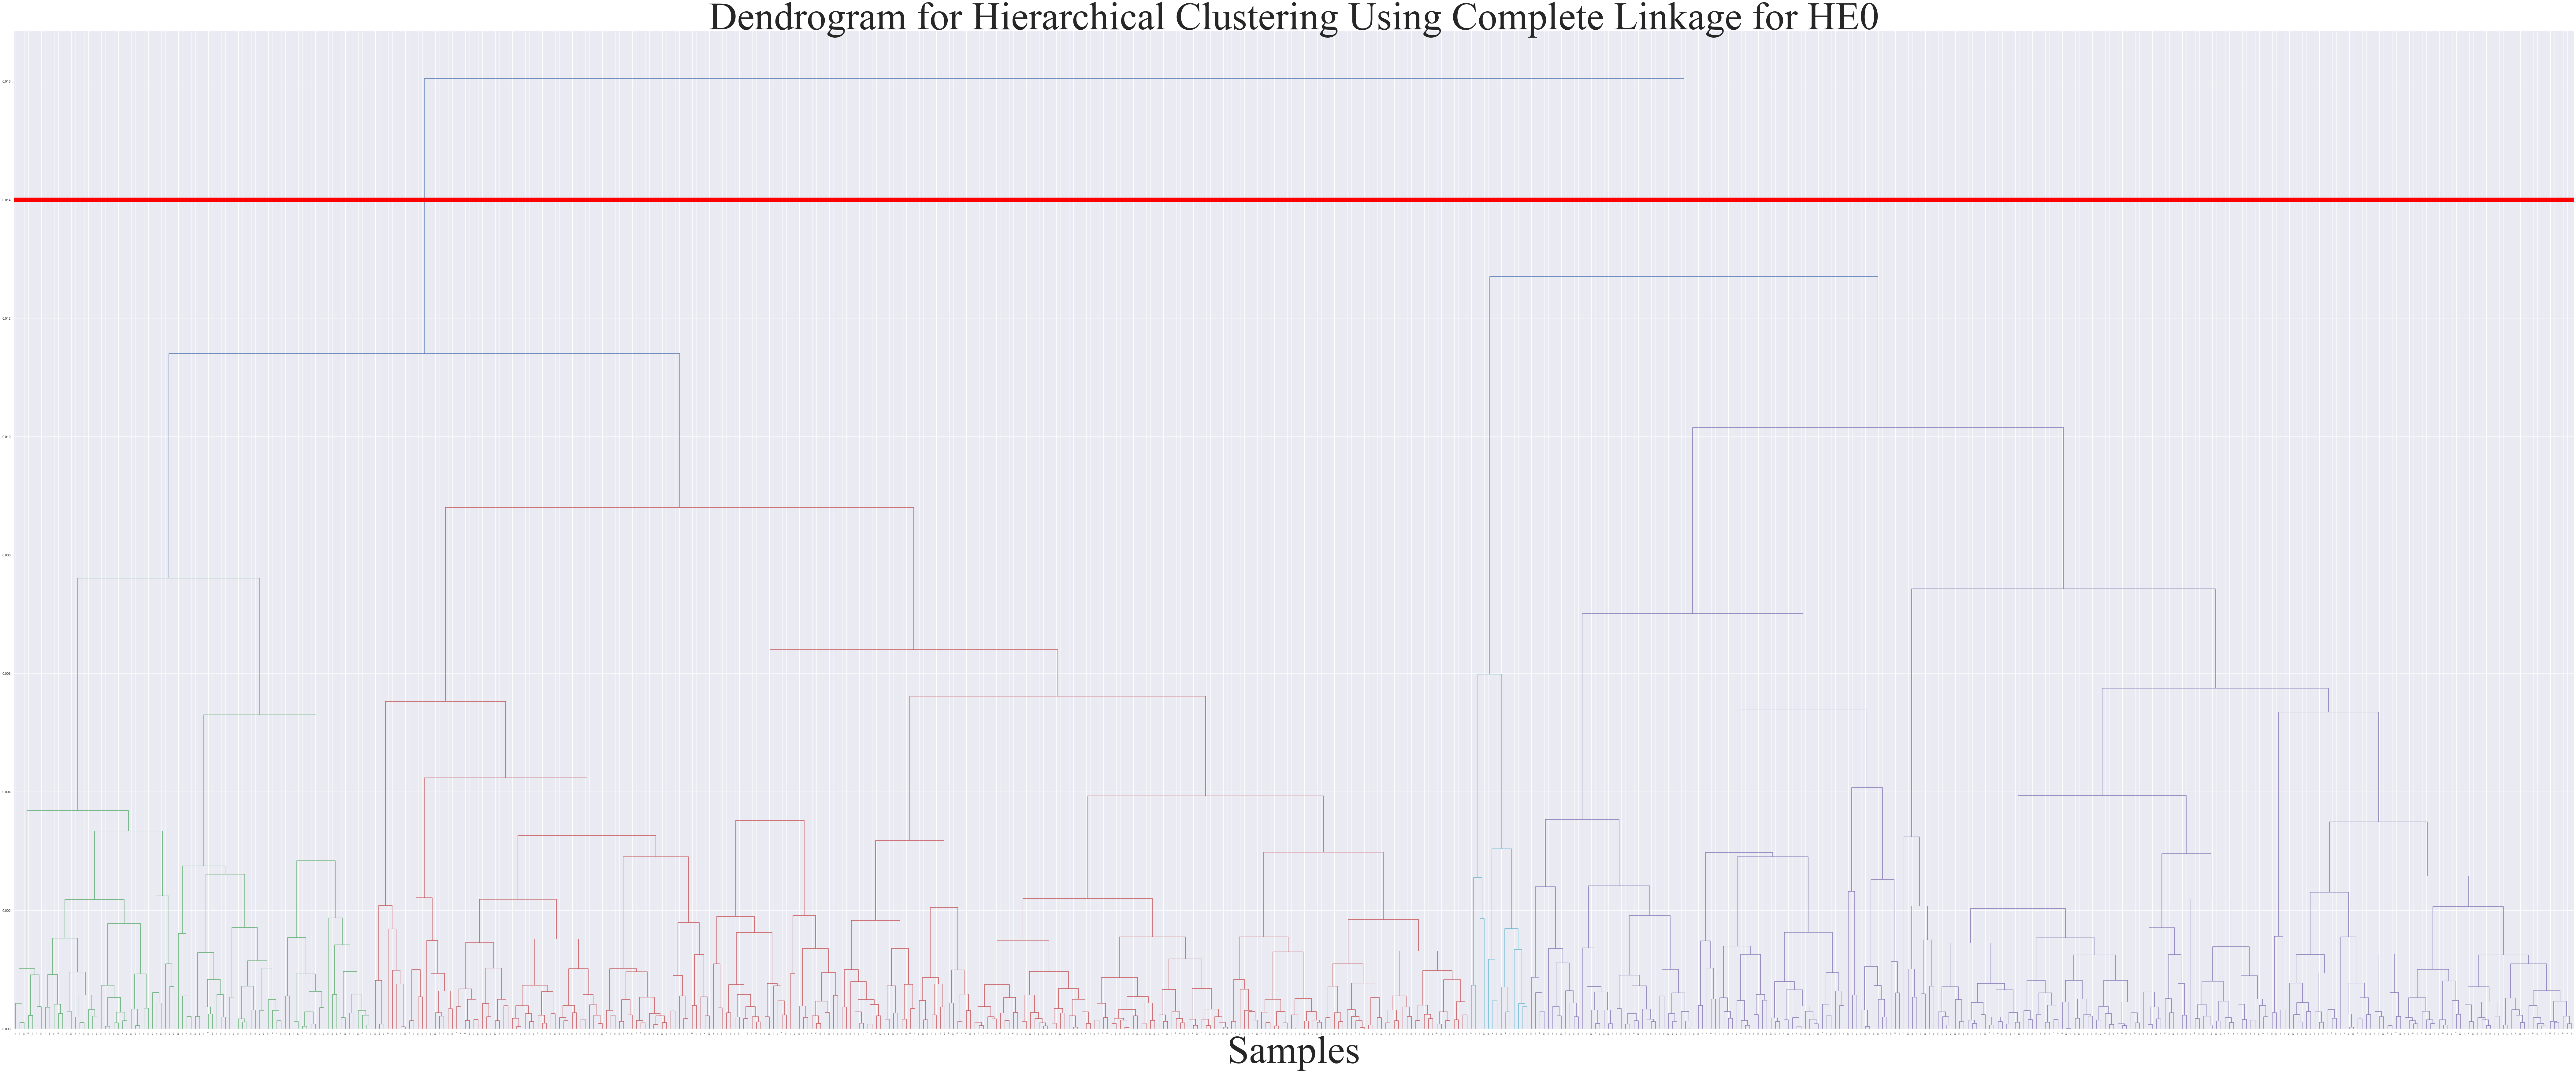

In [53]:
# draw dendrogram and decide number of clusters according to its shape
dH0c = plt.figure(figsize=(150,60))
Z = hierarchy.linkage(hierH0, 'complete')
hierarchy.dendrogram(Z)
print("We decide to use 2 clusters by cutting dendrogram like this:")
plt.axhline(0.014, 0, 3,color="red",linewidth = '15')
plt.xlabel('Samples',font1)
plt.title('Dendrogram for Hierarchical Clustering Using Complete Linkage for HE0',font1)

plt.show()

We decide to use 3 clusters by cutting dendrogram like this:


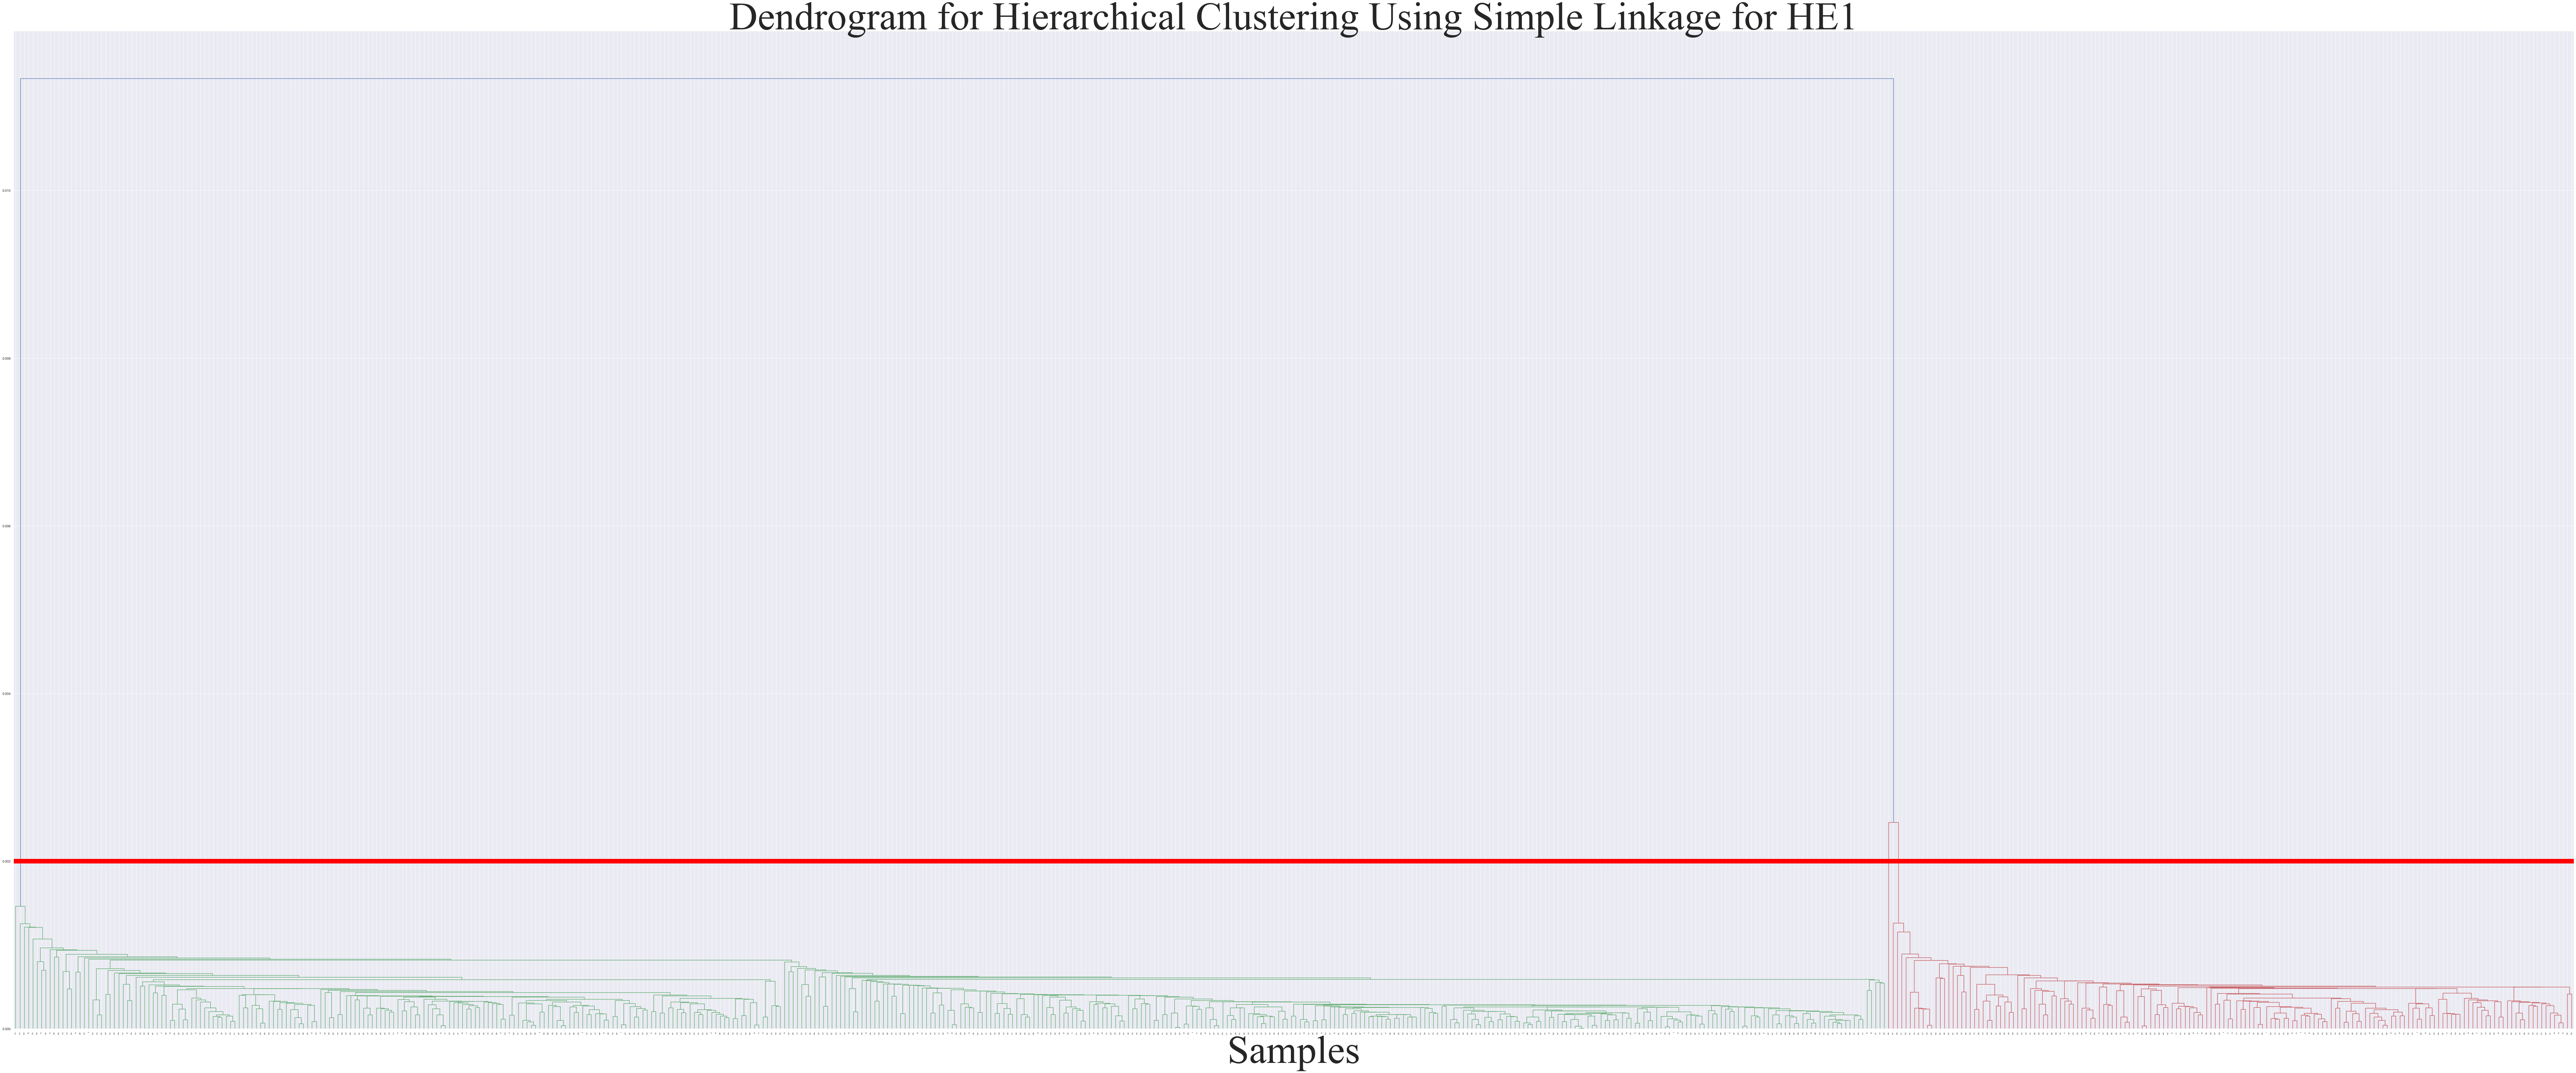

In [54]:
# draw dendrogram and decide number of clusters according to its shape
dH1c = plt.figure(figsize=(150,60))
Z = hierarchy.linkage(hierH1, 'single')
hierarchy.dendrogram(Z)
print("We decide to use 3 clusters by cutting dendrogram like this:")
plt.axhline(0.002, 0, 3,color="red",linewidth = '15')
plt.xlabel('Samples',font1)
plt.title('Dendrogram for Hierarchical Clustering Using Simple Linkage for HE1',font1)

plt.show()

We decide to use 3 clusters by cutting dendrogram like this:


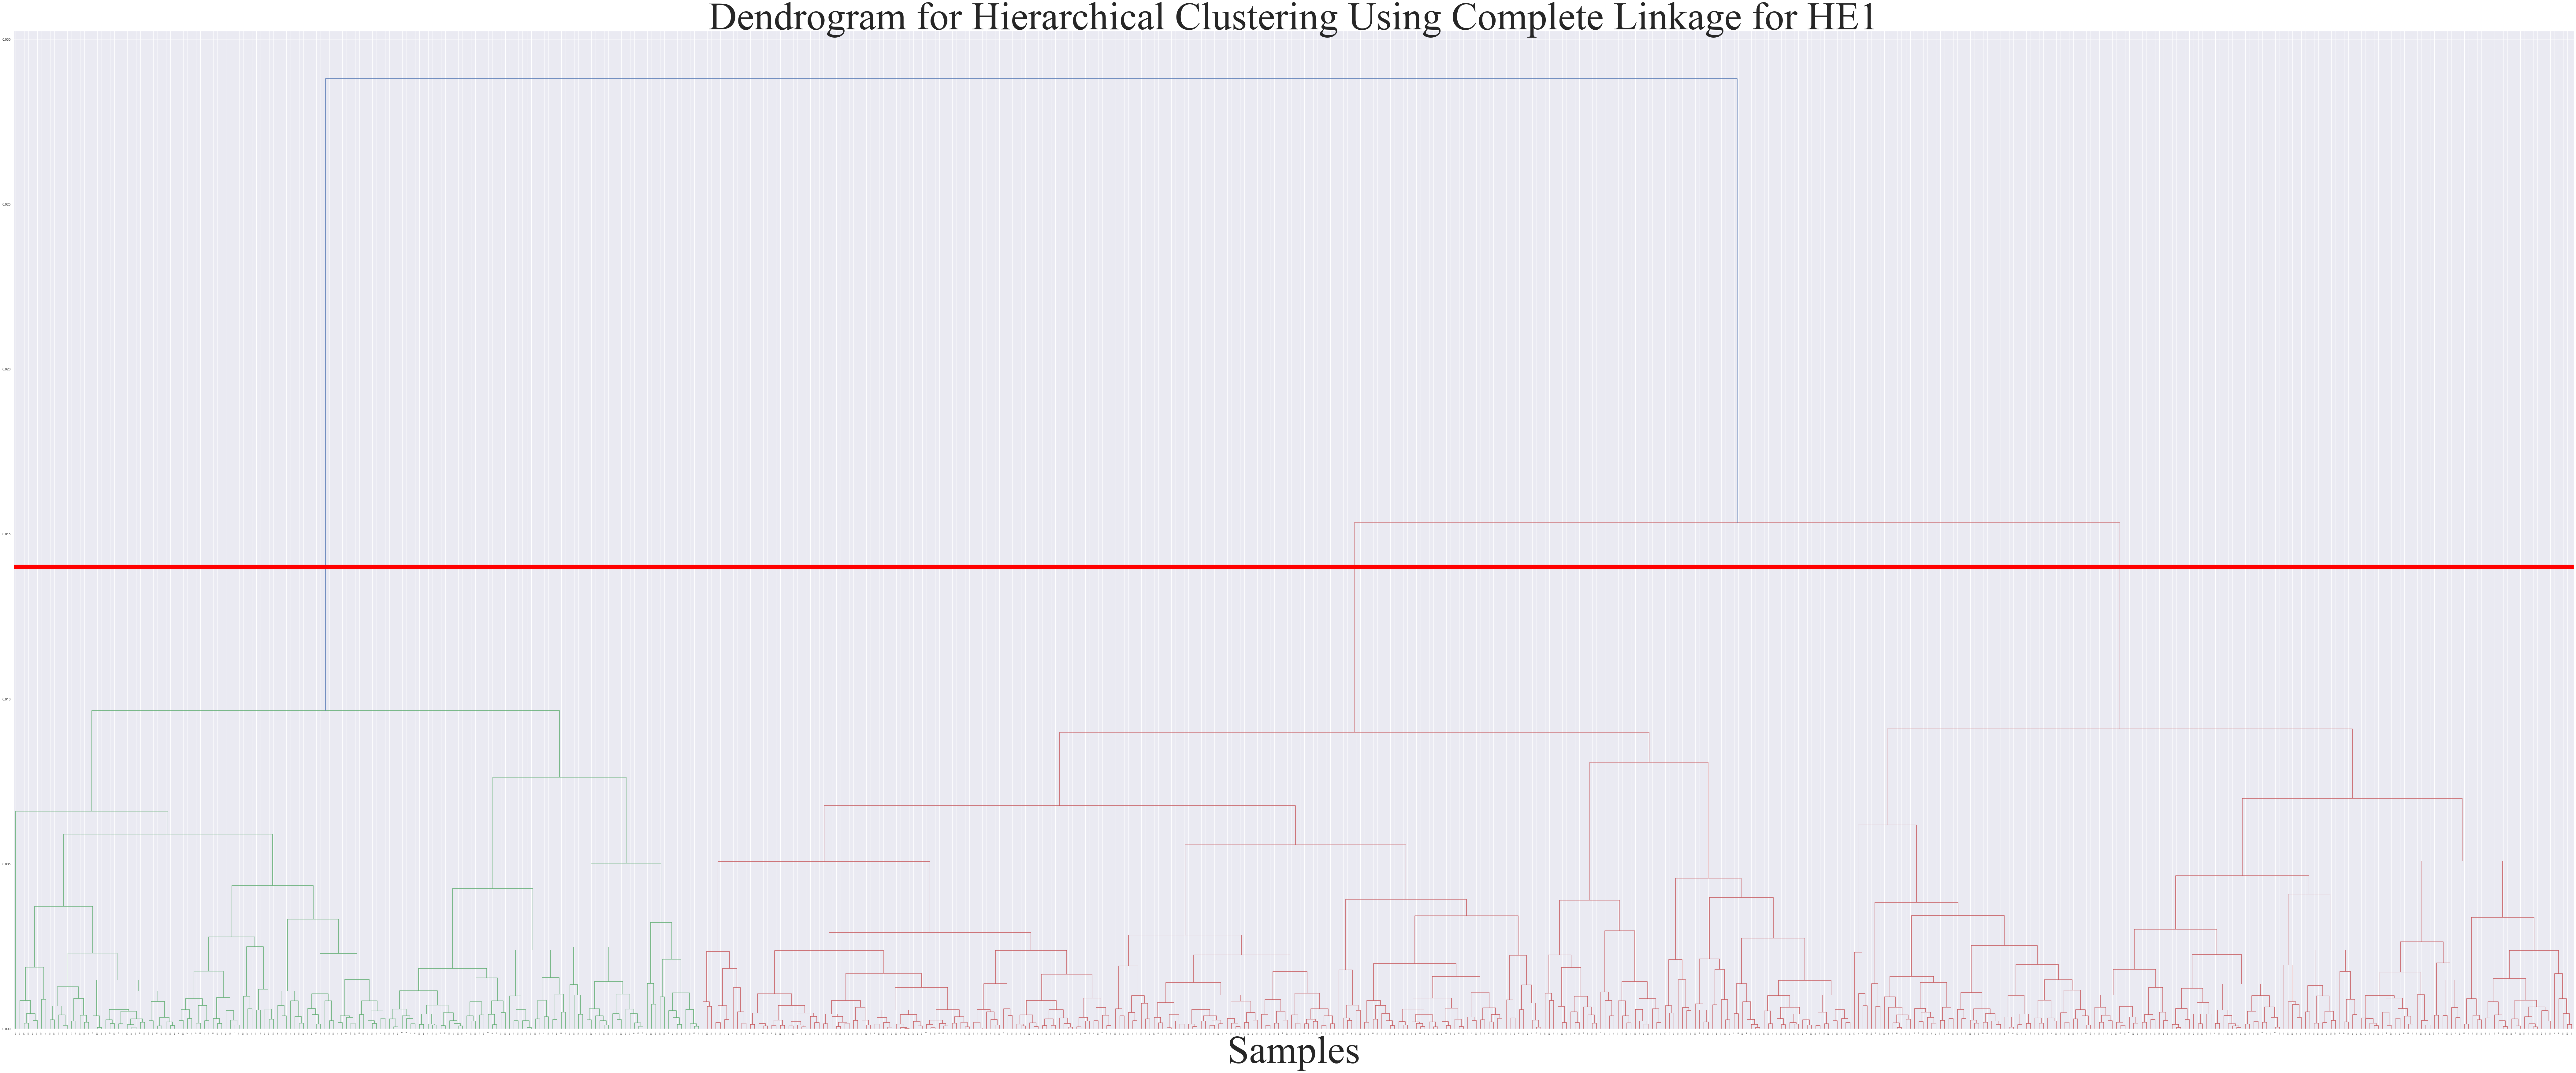

In [55]:
# draw dendrogram and decide number of clusters according to its shape
dH1c = plt.figure(figsize=(150,60))
Z = hierarchy.linkage(hierH1, 'complete')
hierarchy.dendrogram(Z)
print("We decide to use 3 clusters by cutting dendrogram like this:")
plt.axhline(0.014, 0, 3,color="red",linewidth = '15')
plt.xlabel('Samples',font1)
plt.title('Dendrogram for Hierarchical Clustering Using Complete Linkage for HE1',font1)

plt.show()

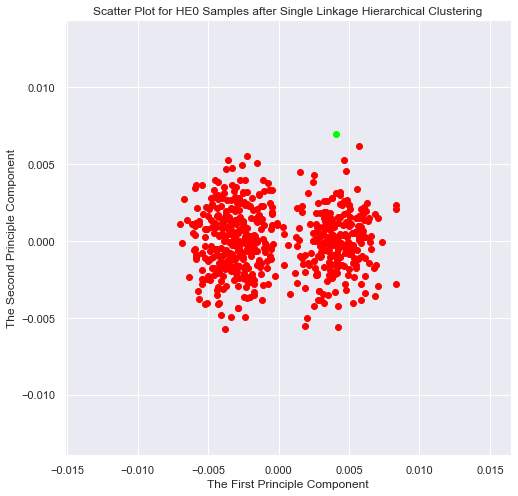

In [56]:
# generate single linkage Hierarchical clustering for HE0 graph
H0single=[[],[]]
for i in range(len(dataH0)):
    H0single[clusH0s.labels_[i]].append(hierH0[i])
plt.figure(figsize=(8,8)) 
plt.scatter(np.array(H0single[0])[:,0],np.array(H0single[0])[:,1],c='#FF0000')
plt.scatter(np.array(H0single[1])[:,0],np.array(H0single[1])[:,1],c='#00FF00')
plt.xlabel('The First Principle Component')
plt.ylabel('The Second Principle Component')
plt.title('Scatter Plot for HE0 Samples after Single Linkage Hierarchical Clustering')

plt.show()

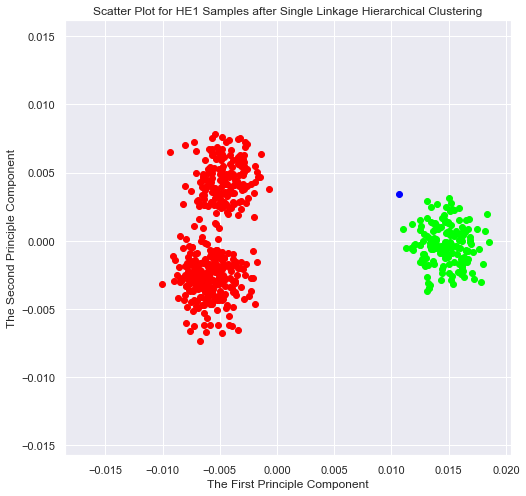

In [57]:
# generate single linkage Hierarchical clustering for HE1 graph
H1single=[[],[],[]]
for i in range(len(dataH1)):
    H1single[clusH1s.labels_[i]].append(hierH1[i])
plt.figure(figsize=(8,8))
plt.scatter(np.array(H1single[0])[:,0],np.array(H1single[0])[:,1],c='#FF0000')
plt.scatter(np.array(H1single[1])[:,0],np.array(H1single[1])[:,1],c='#00FF00')
plt.scatter(np.array(H1single[2])[:,0],np.array(H1single[2])[:,1],c='#0000FF')
plt.xlabel('The First Principle Component')
plt.ylabel('The Second Principle Component')
plt.title('Scatter Plot for HE1 Samples after Single Linkage Hierarchical Clustering')

plt.show()

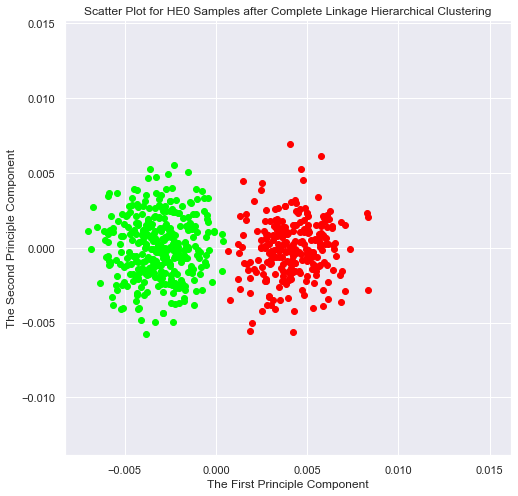

In [58]:
# generate complete linkage Hierarchical clustering for HE0 graph
H0complete=[[],[]]
for i in range(len(dataH0)):
    H0complete[clusH0c.labels_[i]].append(hierH0[i])
plt.figure(figsize=(8,8))
plt.scatter(np.array(H0complete[0])[:,0],np.array(H0complete[0])[:,1],c='#FF0000')
plt.scatter(np.array(H0complete[1])[:,0],np.array(H0complete[1])[:,1],c='#00FF00')
plt.xlabel('The First Principle Component')
plt.ylabel('The Second Principle Component')
plt.title('Scatter Plot for HE0 Samples after Complete Linkage Hierarchical Clustering')

plt.show()

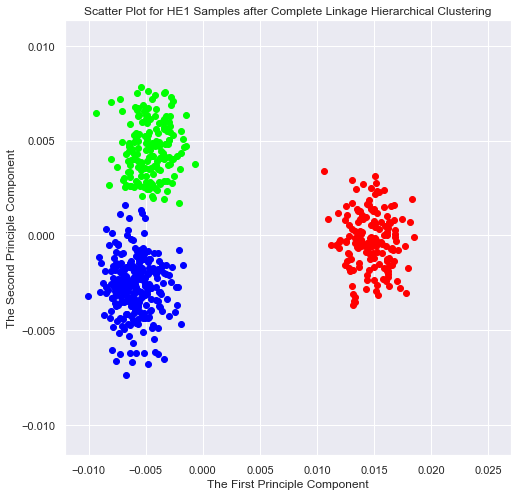

In [59]:
# generate single complete Hierarchical clustering for HE1 graph
H1complete=[[],[],[]]
for i in range(len(dataH1)):
    H1complete[clusH1c.labels_[i]].append(hierH1[i])
plt.figure(figsize=(8,8))
plt.scatter(np.array(H1complete[0])[:,0],np.array(H1complete[0])[:,1],c='#FF0000')
plt.scatter(np.array(H1complete[1])[:,0],np.array(H1complete[1])[:,1],c='#00FF00')
plt.scatter(np.array(H1complete[2])[:,0],np.array(H1complete[2])[:,1],c='#0000FF')
plt.xlabel('The First Principle Component')
plt.ylabel('The Second Principle Component')
plt.title('Scatter Plot for HE1 Samples after Complete Linkage Hierarchical Clustering')

plt.show()

### d. Single vs Complete Link Hierarchical Clustering

$
\text{The difference between the single and complete linkage hierarchical clustering methods is that their ways}\\
\text{to define the distance between two clusters are different. Even though these two methods both start from}\\ 
\text{treating each data point as a cluster and merge two clusters which are most similar (closest) to each other,}\\ 
\text{the single linkage method defines the distance between two clusters as the distance of the closest pair of}\\ 
\text{data objects belonging to different clusters while the complete linkage method defines the distance between}\\ 
\text{two clusters as the distance of the farthest pair of data objects belonging to different clusters.}\\
\ \\
\text{Yes, major differences can be seen from the generated clusters. Specifically, the result from the single linkage}\\ 
\text{method is quite different from the result from the complete linkage method for HE0 data. Besides, the result}\\ 
\text{from the single linkage method is also quite different from the result from the complete linkage method for HE1}\\ 
\text{data. We think that it is the outliers in the data that cause the differences. Since the single linkage method}\\ 
\text{is sensitive to outliers and suffers the chaining effect, the results from the single linkage method will be}\\ 
\text{heavily affected by the outliers in our data. Based on observation, there should be at least one outlier in}\\ 
\text{both the HE0 and HE1 samples, so the performance of the single linkage method is really bad for either the HE0}\\ 
\text{data or the HE1 data. By contrast, the complete linkage method is robust to outliers and prefers spherical}\\ 
\text{clusters, so it performs pretty well for both the HE0 data and the HE1 data.}
$

### e. Comparing Clustering Techniques

$
\text{Intuitively, there should be two clusters in the HE0 data while three clusters in the HE1 data. Except the}\\ 
\text{single linkage hierarchical clustering method, all other methods give really reasonable results. Obtaining}\\ 
\text{reasonable results is expected, because the clusters in the HE0 and the HE1 data are obvious. By contrast,}\\ 
\text{it is the outliers in the HE0 and the HE1 data that cause the unreasonable result from the single linkage}\\ 
\text{hierarchical clustering method. The single linkage hierarchical clustering method is sensitive to outliers,}\\ 
\text{so the outliers in the HE0 and the HE1 data can heavily affect the performance of the single linkage}\\ 
\text{hierarchical clustering method. We select the GMM results for the following analyses.}
$

### f. What do Clusters Represent

$
\text{Generally speaking, the clusters I have found represent subpopulations in HE0 and HE1 samples, respectively.}\\
\text{Specifically, the two clusters I have found in HE0 samples represent the two subpopulations that have}\\ 
\text{significantly different microbial relative abundance in HE0 samples. Similarly, the three clusters I have}\\ 
\text{found in HE1 samples represent the three subpopulations that have significantly different microbial relative}\\ 
\text{abundance in HE1 samples.}\\
\ \\
\textbf{Factors:}\\
\bullet \text{Maybe whether having HE or not is mainly determined by microbial composition.}\\
\text{In HE0 samples, there may be two different types of microbial composition that contribute to not having HE.}\\
\text{Similarly, there may be three different types of microbial composition that contribute to having HE in HE1}\\
\text{samples.}\\ 
\bullet \text{Maybe whether having HE or not is mainly determined by certain types of microbes.}\\
\text{Maybe whether having HE or not is mainly determined by several certain types of microbes that help divide}\\ 
\text{HE0 samples into two subpopulations while HE1 samples into three subpopulations.}
$

### g. Deciding on Number of Clusters

$
\textbf{Factors:}\\
\bullet \text{There is oo much noise.}\\
\text{If there is too much noise, the noise will affect the evaluation of the cluster algorithm, which may suggest}\\ 
\text{an incorrect cluster number.}\\
\bullet \text{Cluster centroids are too close to each other.}\\
\text{If cluster centroids are too close to each other, the evaluation of the cluster algorithm tends to suggest}\\
\text{that some clusters should be merged together while the suggested merging is against our observations.}\\
\bullet \text{The data reveals weak clustering patterns.}\\
\text{If the data reveals really weak clustering patterns by observation, we can only depend on the the evaluation}\\ 
\text{of the cluster algorithm to decide the number of clusters, where it is really easy to use an incorrect cluster}\\ 
\text{number, because we cannot verify the suggested cluster number by our observation.}
$

# Task 4: Interpreting Results

## 1. Identify Microbes with Altered Abundance Levels

### a. Determine if each HE1 Subpopulation shows altered abundance levels

$
\text{We use the clusters generated by the GMM method as the subpopulations to do the following microbe analysis. For}\\ 
\text{every subpopulation in HE0 and HE1 data, we generate a size-149 vector with each element in the vector is the}\\  
\text{average of the relative aboundance of that particlular microbe in the subpolupation. Then, we compare each}\\  
\text{subpopulation in HE1 to each subpopulation in HE0, six comparisons in total, to determine if each HE1 subpopulation}\\  
\text{shows a significantly different microbiome than the HE0 samples.}
$

In [60]:
# get the GMM result for HE0 with k=2 and HE1 with k=3
y_HE0_pred= GaussianMixture(n_components=2, random_state=9).fit_predict(pca_HE0)
y_HE1_pred= GaussianMixture(n_components=3, random_state=9).fit_predict(pca_HE1)

In [61]:
# basic set up
# divide HE1 samples into three subpopulations
HE1_a=[]
HE1_b=[]
HE1_c=[]

# divide HE0 samples into two subpopulations
HE0_a=[]
HE0_b=[]

# map the clusters in low dimension to the original dimension
for i in range(len(dataH1)):
    if y_HE1_pred[i]==0:#set the cluster with label 0 in HE1 GMM as the HE1_a group
        HE1_a.append(list(dataH1[i]))
    if y_HE1_pred[i]==1:#set the cluster with label 1 in HE1 GMM as the HE1_b group
        HE1_b.append(list(dataH1[i]))
    if y_HE1_pred[i]==2:#set the cluster with label 2 in HE1 GMM as the HE1_c group
        HE1_c.append(list(dataH1[i]))
for i in range(len(dataH0)):
    if y_HE0_pred[i]==0:#set the cluster with label 0 in HE0 GMM as the HE0_a group
        HE0_a.append(list(dataH0[i]))
    if y_HE0_pred[i]==1:#set the cluster with label 1 in HE0 GMM as the HE0_b group
        HE0_b.append(list(dataH0[i]))
        
# calculate the average vector for every high dimension cluster
vector_1a=np.zeros(149)
vector_1b=np.zeros(149)
vector_1c=np.zeros(149)
vector_0a=np.zeros(149)
vector_0b=np.zeros(149)

for j in range(len(HE1_a)):
    for i in range(149):
        vector_1a[i]+=HE1_a[j][i]
vector_1a=vector_1a/len(HE1_a)

for j in range(len(HE1_b)):
    for i in range(149):
        vector_1b[i]+=HE1_b[j][i]
vector_1b=vector_1b/len(HE1_b)
    
for j in range(len(HE1_c)):
    for i in range(149):
        vector_1c[i]+=HE1_c[j][i]
vector_1c=vector_1c/len(HE1_c)

for j in range(len(HE0_a)):
    for i in range(149):
        vector_0a[i]+=HE0_a[j][i]
vector_0a=vector_0a/len(HE0_a)

for j in range(len(HE0_b)):
    for i in range(149):
        vector_0b[i]+=HE0_b[j][i]
vector_0b=vector_0b/len(HE0_b)

$
\text{In the comparison, we make use of percentage difference to compare relative abundance. In each comparison, we}\\ 
\text{calculate the percentage difference between the two compared subpopulations for each microbe, forming a size-149}\\  
\text{percentage difference vector.}\\ 
$

In [62]:
# generate six comparison vector (the percentage difference between two subpopulations)
# calculation of percentage difference: 100 * (a-b) / a
p_1a0a = np.zeros(149)
p_1a0b = np.zeros(149)
p_1b0a = np.zeros(149)
p_1b0b = np.zeros(149)
p_1c0a = np.zeros(149)
p_1c0b = np.zeros(149)

# generate percentage difference vectors
for i in range(149):
    p_1a0a[i] = abs((vector_1a[i]-vector_0a[i])/(vector_1a[i]))
    p_1a0b[i] = abs((vector_1a[i]-vector_0b[i])/(vector_1a[i]))
    p_1b0a[i] = abs((vector_1b[i]-vector_0a[i])/(vector_1b[i]))
    p_1b0b[i] = abs((vector_1b[i]-vector_0b[i])/(vector_1b[i]))
    p_1c0a[i] = abs((vector_1c[i]-vector_0a[i])/(vector_1c[i]))
    p_1c0b[i] = abs((vector_1c[i]-vector_0b[i])/(vector_1c[i]))


print('Percentage difference of relative abundance for each microbe between HE1_a and HE0_a:\n',p_1a0a)

print('\nPercentage difference of relative abundance for each microbe between HE1_a and HE0_b:\n',p_1a0b)

print('\nPercentage difference of relative abundance for each microbe between HE1_b and HE0_a:\n',p_1b0a)

print('\nPercentage difference of relative abundance for each microbe between HE1_b and HE0_b:\n',p_1b0b)

print('\nPercentage difference of relative abundance for each microbe between HE1_c and HE0_a:\n',p_1c0a)

print('\nPercentage difference of relative abundance for each microbe between HE1_c and HE0_b:\n',p_1c0b)

Percentage difference of relative abundance for each microbe between HE1_a and HE0_a:
 [0.07763202 0.1350086  0.04706317 0.0310511  0.0709077  0.01124167
 0.08462375 0.0525508  0.06761165 0.06842444 0.05222446 0.00832482
 0.04320122 0.07807881 0.09917138 0.04976107 0.03238389 0.03386898
 0.06706514 0.05103867 0.01497407 0.0582533  0.0571862  0.06207126
 0.07250742 0.06844975 0.08176863 0.08165898 0.06048431 0.00989505
 0.022871   0.02398857 0.0738067  0.07880697 0.15667379 0.0826214
 0.08910274 0.03771737 0.09640103 0.01494192 0.07442868 0.04269155
 0.06308236 0.15503309 0.06710598 0.05175889 0.1008455  0.04810709
 0.06692219 0.10122236 0.0933808  0.0378573  0.05698855 0.11600179
 0.0747174  0.07354059 0.02642915 0.05948878 0.16320485 0.06009768
 0.047705   0.00824143 0.11875108 0.02218742 0.09497044 0.02048933
 0.02857943 0.0538999  0.04946337 0.09385352 0.05642461 0.10924308
 0.08045684 0.05414221 0.08862946 0.0645582  0.1162964  0.0617266
 0.01775602 0.08046755 0.07250545 0.04228415

$
\text{To get an intuition of the difference of the microbiome between subpopulations, we must get rid of the}\\ 
\text{influence of some small percentage differences. Thus, we set a threshold to eliminate the effect of the}\\  
\text{small percentage differences. In other words, we do not consider the percentage diference smaller than}\\  
\text{or equal to 15% as a sign for microbial relative abundance difference. We only consider the percentage}\\  
\text{difference greater than 15% as a sign for microbial relative aboundance difference. Then, we count the}\\  
\text{number of microbes that have a significantly altered abundance for each comparison.}
$

In [63]:
# detect for the combination of subpopulations that has significant difference of microbiome 
count_p_1a0a = 0
count_p_1a0b = 0
count_p_1b0a = 0
count_p_1b0b = 0
count_p_1c0a = 0
count_p_1c0b = 0


for i in range(149):
    if p_1a0a[i]>0.15 :
        count_p_1a0a += 1
    if p_1a0b[i]>0.15 :
        count_p_1a0b += 1
    if p_1b0a[i]>0.15:
        count_p_1b0a += 1
    if p_1b0b[i]>0.15:
        count_p_1b0b += 1
    if p_1c0a[i]>0.15:
        count_p_1c0a += 1
    if p_1c0b[i]>0.15:
        count_p_1c0b += 1
        
print("at 0.15 level:")
print('\nHE1_a and HE0_a:',
      '\nNumber of significantly different microbiome:', count_p_1a0a,
      '\n\nHE1_a and HE0_b:',
      '\nNumber of significantly different microbiome:', count_p_1a0b,
      '\n\nHE1_b and HE0_a:',
      '\nNumber of significantly different microbiome:', count_p_1b0a,
      '\n\nHE1_b and HE0_b:',
      '\nNumber of significantly different microbiome:', count_p_1b0b,
      '\n\nHE1_c and HE0_a:',
      '\nNumber of significantly different microbiome:', count_p_1c0a,
      '\n\nHE1_c and HE0_b:',
      '\nNumber of significantly different microbiome:', count_p_1c0b)


at 0.15 level:

HE1_a and HE0_a: 
Number of significantly different microbiome: 3 

HE1_a and HE0_b: 
Number of significantly different microbiome: 0 

HE1_b and HE0_a: 
Number of significantly different microbiome: 14 

HE1_b and HE0_b: 
Number of significantly different microbiome: 22 

HE1_c and HE0_a: 
Number of significantly different microbiome: 0 

HE1_c and HE0_b: 
Number of significantly different microbiome: 8


$
\textbf{Criteria:}\\
\text{1) If the percentage difference is larger than 15%, we consider the corresponding microbe to have a significantly altered abundance.}\\
\text{2) If more than five microbes have a significantly altered abundance, we consider the microbiome to be significantly different.}\\
\ \\
\text{Based on our analysis and the criteria we define, we obtain the following information.}\\
\bullet \text{HE1_a subpopulation has no significantly different microbiome than the HE0_a or HE0_b subpopulations.}\\
\bullet \text{HE1_b subpopulation has a significantly different microbiome than both the HE0_a and HE0_b subpopulations.}\\
\bullet \text{HE1_c subpopulation has a significantly different microbiome only than the HE0_b subpopulation.}\\
$

### b. Identify Most Similar HE0 Clusters to Affected HE1 Clusters

$
\text{For this problem, we can directly make use of the results from Task 4.1.a, because the decision process is the same.}\\
\bullet \text{For HE1_b subpopulation, it is most similar to HE0_a subpopulation, because there are 14 microbes that have a}\\ 
\ \ \text{significantly altered abundance between HE1_b and HE0_a subpopulations while 22 microbes that have a significantly}\\ 
\ \ \text{altered abundance between HE1_b and HE0_b subpopulations.}\\
\bullet \text{For HE1_c subpopulation, it is most similar to HE0_a subpopulation, because there are no microbes that have a}\\ 
\ \ \text{significantly altered abundance between HE1_c and HE0_a subpopulations while 8 microbes that have a significantly}\\
\ \ \text{altered abundance between HE1_c and HE0_b subpopulations.}
$

### c. Identify Microbes with Significantly Altered Relative Abundance

In [64]:
alpha = 0.0000025

# compare HE1_b with HE0_a
p_val_mic = []
mic_index_1 = []
HE1_b_arr = np.array(HE1_b)
HE0_a_arr = np.array(HE0_a)

# apply KS test
for i in range(HE1_b_arr.shape[1]):
    st_value,p_value = st.ks_2samp(HE1_b_arr[:,i],  HE0_a_arr[:,i])
    p_val_mic.append(p_value)

# look for microbe index
for i in range(len(p_val_mic)):
    if p_val_mic[i] <= alpha: # significantly altered
        mic_index_1.append(i)

print('Comparing HE1_b and HE0_a subpopulations')
print('Identify',len(mic_index_1),'microbes with significantly altered abundance:\n')
for i in mic_index_1:
    print(data_gn_HE0.index[i])    

Comparing HE1_b and HE0_a subpopulations
Identify 19 microbes with significantly altered abundance:

Actinobacteria_Actinobacteria_Actinomycetales_Corynebacteriaceae
Actinobacteria_Actinobacteria_Actinomycetales_Nakamurellaceae
Actinobacteria_Actinobacteria_Actinomycetales_Propionibacteriaceae
Bacteroidetes_Bacteroidia_Bacteroidales_Bacteroidales_incertae_sedis
Bacteroidetes_Flavobacteriia_Flavobacteriales_Cryomorphaceae
Bacteroidetes_Sphingobacteriia_Sphingobacteriales_Sphingobacteriaceae
Chrysiogenetes_Chrysiogenetes_Chrysiogenales_Chrysiogenaceae
Firmicutes_Bacilli_Bacillales_Bacillales_Incertae Sedis XI
Firmicutes_Bacilli_Lactobacillales_Lactobacillaceae
Firmicutes_Clostridia_Clostridiales_Clostridiales_Incertae Sedis XIII
Firmicutes_Clostridia_Halanaerobiales_Halanaerobiaceae
Parvarchaeota_Candidatus Parvarchaeum_Candidatus Parvarchaeum_Candidatus Parvarchaeum
Proteobacteria_Alphaproteobacteria_Rhizobiales_Brucellaceae
Proteobacteria_Alphaproteobacteria_Rhizobiales_Hyphomicrobiace

In [65]:
# compare HE1_c with HE0_a
p_val_mic = []
mic_index_2 = []
HE1_c_arr = np.array(HE1_c)
HE0_a_arr = np.array(HE0_a)

# apply KS test
for i in range(HE1_c_arr.shape[1]):
    st_value,p_value = st.ks_2samp(HE1_c_arr[:,i],  HE0_a_arr[:,i])
    p_val_mic.append(p_value)

# look for microbe index
for i in range(len(p_val_mic)):
    if p_val_mic[i] <= alpha: # significantly altered
        mic_index_2.append(i)

print('Comparing HE1_c and HE0_a subpopulations')
print('Identify',len(mic_index_2),'microbes with significantly altered abundance:\n')
for i in mic_index_2:
    print(data_gn_HE0.index[i])

Comparing HE1_c and HE0_a subpopulations
Identify 0 microbes with significantly altered abundance:



## 2. Identify How Abundance Changes

### a. Microbes which increase and decrease

In [66]:
inc = []
dec = []

for i in mic_index_1:
    if 0 < vector_1b[i] - vector_0a[i]:
        inc.append(data_gn_HE0.index[i])
    else:
        dec.append(data_gn_HE0.index[i])
        
print('Microbes that show an increase\n')
for i in inc:
    print(i)
    
print('\nMicrobes that show an decrease\n')
for i in dec:
    print(i)

Microbes that show an increase

Actinobacteria_Actinobacteria_Actinomycetales_Nakamurellaceae
Actinobacteria_Actinobacteria_Actinomycetales_Propionibacteriaceae
Bacteroidetes_Sphingobacteriia_Sphingobacteriales_Sphingobacteriaceae
Chrysiogenetes_Chrysiogenetes_Chrysiogenales_Chrysiogenaceae
Firmicutes_Bacilli_Bacillales_Bacillales_Incertae Sedis XI
Firmicutes_Clostridia_Halanaerobiales_Halanaerobiaceae
Parvarchaeota_Candidatus Parvarchaeum_Candidatus Parvarchaeum_Candidatus Parvarchaeum
Proteobacteria_Alphaproteobacteria_Rhizobiales_Brucellaceae
Proteobacteria_Alphaproteobacteria_Rhizobiales_Hyphomicrobiaceae
Proteobacteria_Alphaproteobacteria_SAR11_SAR11

Microbes that show an decrease

Actinobacteria_Actinobacteria_Actinomycetales_Corynebacteriaceae
Bacteroidetes_Bacteroidia_Bacteroidales_Bacteroidales_incertae_sedis
Bacteroidetes_Flavobacteriia_Flavobacteriales_Cryomorphaceae
Firmicutes_Bacilli_Lactobacillales_Lactobacillaceae
Firmicutes_Clostridia_Clostridiales_Clostridiales_Incert

### b. Biological Relations

$
\text{Taxonomical groups:}\\
\ \\
\textbf{Actinobacteria:}\\
\text{Actinobacteria_Actinobacteria_Actinomycetales_Corynebacteriaceae}\\
\text{Actinobacteria_Actinobacteria_Actinomycetales_Nakamurellaceae}\\
\text{Actinobacteria_Actinobacteria_Actinomycetales_Propionibacteriaceae}\\
\ \\
\textbf{Bacteroidetes:}\\
\text{Bacteroidetes_Bacteroidia_Bacteroidales_Bacteroidales_incertae_sedis}\\
\text{Bacteroidetes_Flavobacteriia_Flavobacteriales_Cryomorphaceae}\\
\text{Bacteroidetes_Sphingobacteriia_Sphingobacteriales_Sphingobacteriaceae}\\
\ \\
\textbf{Firmicutes:}\\
\text{Firmicutes_Bacilli_Bacillales_Bacillales_Incertae Sedis XI}\\
\text{Firmicutes_Bacilli_Lactobacillales_Lactobacillaceae}\\
\text{Firmicutes_Clostridia_Clostridiales_Clostridiales_Incertae Sedis XIII}\\
\text{Firmicutes_Clostridia_Halanaerobiales_Halanaerobiaceae}\\
\ \\
\textbf{Proteobacteria:}\\
\text{Proteobacteria_Alphaproteobacteria_Rhizobiales_Brucellaceae}\\
\text{Proteobacteria_Alphaproteobacteria_Rhizobiales_Hyphomicrobiaceae}\\
\text{Proteobacteria_Alphaproteobacteria_Rhizobiales_Rhizobiaceae}\\
\text{Proteobacteria_Alphaproteobacteria_SAR11_SAR11}\\
\text{Proteobacteria_Betaproteobacteria_Burkholderiales_Burkholderiaceae}\\
\text{Proteobacteria_Betaproteobacteria_Rhodocyclales_Rhodocyclaceae}\\
\text{Proteobacteria_Gammaproteobacteria_Orbales_Orbaceae}
$